# Please read the [README](https://github.com/ibudiselic/covid/blob/master/README.md) file in this repository.

In [1]:
# Data processing and globals.

import csv
import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Markdown, Latex
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import curve_fit
from scipy.special import exp10

%matplotlib notebook
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.max_open_warning'] = 0

# CSV keys.
KEY_COUNTRY = 1
KEY_DATES_START = 4
# Number of days to extend projections by.
DAYS_EXTEND = 7
# `plot` kwargs to use for data lines to make them stand out vs. projections.
DATALINE_KWARGS = {'marker': 'x', 'markersize': 7, 'linewidth': 3}


# Returns a proper `datetime` from `date_str` in a format like
# '1/22/20', which represents January 22nd, 2020.
def make_date(date_str):
    parts = date_str.split('/')
    assert(len(parts) == 3)
    return datetime.date(2000 + int(parts[2]), int(parts[0]), int(parts[1]))


def delta_series(lst):
    if len(lst) < 2:
        return []
    return [x-y for x,y in zip(lst[1:], lst)]


class Country(object):
    def __init__(self, name, population, series_data):
        self.name = name
        self.population = population
        self.timeseries = series_data
        self.timeseries['active'] = (
            [c-a-d for c, a, d in zip(self.timeseries['confirmed'], self.timeseries['recovered'], self.timeseries['dead'])])

    def get(self, series, perm=False):
        factor = 1000.0/self.population if perm else 1.0
        return [v*factor for v in self.timeseries[series]]
    
    # Return new cases per day in the series, starting with the second date, up to the latest date.
    def get_new(self, series):
        return delta_series(self.timeseries[series])
            

def read_one_data_series(series):
    country_data = dict()
    with open(f'data/{series}.csv') as fin:
        reader = csv.reader(fin, delimiter=',', quotechar='"')
        header = next(reader)
        dates = [make_date(date_str) for date_str in header[KEY_DATES_START:]]
        for line in reader:
            name = line[KEY_COUNTRY]
            vals = [int(v) for v in line[KEY_DATES_START:]]
            assert(len(vals) == len(dates))
            if name not in country_data:
                country_data[name] = vals
            else:
                # Another province/state for the same country.
                # We just sum this up.
                cur = country_data[name]
                assert(len(cur) == len(vals))
                for i in range(len(cur)):
                    cur[i] += vals[i]
    return dates, country_data


class DB(object):
    def __init__(self):
        self.dates = None
        # {country name -> {series name -> timeseries numbers}}
        per_country = defaultdict(dict)
        for series in ['confirmed', 'recovered', 'dead']:
            dates, country_data = read_one_data_series(series)
            if self.dates is None:
                self.dates = dates
            else:
                # We're assuming all the dates are present in all the datasets.
                assert(self.dates == dates)
            if len(per_country) > 0:
                assert(set(per_country.keys()) == set(country_data.keys()))
            for country, vals in country_data.items():
                per_country[country][series] = vals

        # {country name -> population}
        populations = dict()
        with open('data/country_population.txt') as fin:
            for line in fin:
                parts = line.split(' ')
                populations[' '.join(parts[:-1])] = int(parts[-1])
        # {country name -> Country}
        self.countries = dict()
        for name, series_data in per_country.items():
            try:
                pop = populations[name]
            except:
                print('Missing population for', name)
                pop = 1
            self.countries[name] = Country(name, pop, series_data)

    def country(self, country_name):
        return self.countries[country_name]


def identity(lst):
    return lst


def log(lst):
    return [None if x == 0 else math.log10(x) for x in lst]


def latex_scientific(numstr):
    p = numstr.find('e')
    if p == -1:
        return numstr
    k = numstr[:p]
    e = int(numstr[p+1:])
    return fr'{k} \times 10^{{{e}}}'


def exponential(t, a, b):
    return a * exp10(b * t)


def display_exponential(prefix, a, b):
    doubling_days = math.log10(2) / b
    latex_a = latex_scientific(f'{a:.3g}')
    display(Latex(fr'{prefix}: \({latex_a} \times 10^{{{b:.3f}t}}\) (doubling rate \({doubling_days:.1f}\) days)'))


def sigmoid(t, a, b, c):
    return a / (1.0 + exp10(-b * (t - c)))


def display_sigmoid(prefix, a, b, c):
    display(Latex(fr'{prefix}: \(\dfrac{{{a:,.1f}}}{{1 + 10^{{-{b:.3f} (t - {c:.1f})}}}}\) (asimptote \({a:,.1f}\))'))


# Returns a plt, ax pair with a size that works well with `%matplotlib notebook`.
def get_plot():
    return plt.subplots(figsize=(12, 8))


# Returns dates and data starting from the first day where the value is at least
# `start_val_perm` per thousand in the given country, regardless of whether the data
# needs to be returned per thousand or not (which is controlled with `perm`).
def get_start_and_align(country_name, series, start_val_perm, perm):
    country = db.country(country_name)
    data = country.get(series, perm=perm)
    start_val = start_val_perm if perm else start_val_perm * country.population / 1000.0
    for i, (t, val) in enumerate(zip(db.dates, data)):
        if val >= start_val:
            return db.dates[i:], data[i:]
    print(f'{country_name} doesn\'t yet have {start_val:.4f} {series} per thousand.')
    return [], []


def get_fit_params(fn, data, **kwargs):
    params, _ = curve_fit(fn, np.arange(1, len(data) + 1), data, **kwargs)
    return params


def should_fit_lines(data):
    return len(data) >= 5 and data[-1] >= 10
        

def backpredict_exp_vs_sigmoid(ax, dates_all, data_all, backpredict_days):
    got_any_sigmoid = False
    ts_extended = np.arange(1, len(data_all) + 1 + DAYS_EXTEND)
    dates_extended = dates_all[::] + [dates_all[-1] + datetime.timedelta(days=d) for d in range(1, DAYS_EXTEND + 1)]
    
    backpredict_days = min(backpredict_days, len(data_all) - 2)
    for backd in range(0, backpredict_days + 1):
        data = data_all if backd == 0 else data_all[:-backd]
        if not should_fit_lines(data):
            break
        aexp, bexp = get_fit_params(exponential, data, p0=(1, 0.1))
        try:
            asig, bsig, csig = get_fit_params(sigmoid, data, p0=(data[-1], 0.2, 21))
        except:
            asig = None

        alpha = (backpredict_days + 1 - backd) / (backpredict_days + 1)
        lw = alpha * 2.0
        style = '-' if backd == 0 else '--'
        ax.plot(
            dates_extended,
            exponential(ts_extended, aexp, bexp),
            'C1',
            linestyle=style,
            linewidth=lw,
            alpha=alpha,
            label='Best fit exponential' if backd == 0 else None)
        if asig is not None:
            ax.plot(
                dates_extended,
                sigmoid(ts_extended, asig, bsig, csig),
                'C2',
                linestyle=style,
                linewidth=lw,
                alpha=alpha,
                label='Best fit sigmoid' if not got_any_sigmoid else None)
            got_any_sigmoid = True
    return got_any_sigmoid
    
    
# `start_info` must be a pair where the 0th element is the number of cases per thousand where the
# analysis starts, and the 1st element is a textual description of that condition.
# `backpredict_days` is the number of the most recent days for which exponential and sigmoid fits are
# plotted, in addition to the latest day.
def analyze_country(country, series, start_info, backpredict_days=0, fit_lines=True):
    dates, data = get_start_and_align(country, series, start_val_perm=start_info[0], perm=False)
    if not data:
        return
    if not should_fit_lines(data):
        fit_lines = False
    display(Markdown(f'### {series.title()}'))
    display(Markdown(f'Start date {dates[0]} (1st day with {start_info[1]})'))
    display(Markdown(fr'Latest number \\({data[-1]:,.0f}\\) on {dates[-1]}'))
    
    if fit_lines:
        # This computation is duplicated in `backpredict_exp_vs_sigmoid` a few lines down, but we want
        # to write out the formulas above the chart, and this seems the easiest way to do that.
        aexp, bexp = get_fit_params(exponential, data, p0=(1, 0.1))
        display_exponential('Best fit exponential', aexp, bexp)
        try:
            asig, bsig, csig = get_fit_params(sigmoid, data, p0=(data[-1], 0.2, 21)) 
            display_sigmoid('Best fit sigmoid', asig, bsig, csig)
        except:
            pass
  
    _, ax = get_plot()
    if fit_lines:
        got_any_sigmoid = backpredict_exp_vs_sigmoid(ax, dates, data, backpredict_days)
    ax.plot(dates, data, 'C0', label=f'{country} {series}', **DATALINE_KWARGS)
    
    if fit_lines:
        ax.set_title(f'Exponential{" and sigmoid" if got_any_sigmoid else ""} fit for {series} in {country},'
                    + f' starting from {start_info[1]}')
    else:
        ax.set_title(f'{series.title()} for {country}, starting from {start_info[1]}')
    ax.legend()
    plt.tight_layout()
    
    if len(data) > 1:
        _, ax = get_plot()
        ax.set_title(f'New {series} per day ({country})')
        ax.bar(dates[1:], delta_series(data))
        plt.tight_layout()


def country_deep_dive(country):
    display(Markdown(f'## {country}'))
    analyze_country(country, 'confirmed', start_info=(0.001, '1 confirmed per million'), backpredict_days=5)
    analyze_country(country, 'dead', start_info=(0.0001, '0.1 dead per million'), backpredict_days=5)
    analyze_country(country, 'active', start_info=(0.001, '1 active per million'), fit_lines=False)
    

# Returns a list of (name, %-recovered) pairs for all "recovering" countries, where a country is defined
# as "recovering" if:
#   - of the last 7 days, the number of active cases has decreased on at least 5 (this is to account
#     for some weird reporting artifacts that can make it appear some country is "recovering" but
#     actually isn't),
#   - the number of active cases has been lower than its all-time-high number of active cases for at least
#     the last 5 days,
#   - the all-time-high was at least 300 cases (there are some countries which never had more than a few
#     cases, so they are not very interestring to look at).
#
# The countries are ordered by decreasing relative "recoverdness".
def get_recovering_countries_info():
    recovered = []
    for country_name, country in db.countries.items():
        if country_name == 'Diamond Princess':
            continue
        active = country.get('active')
        if len(active) < 8 or sum(1 if d<0 else 0 for d in delta_series(active[-8:])) < 5:
            continue
        max_active = max(active)
        if max_active < 300:
            continue
        if all(active[-i] < max_active for i in range(1, 6)):
            recovered.append((country_name, (1 - active[-1] / max_active) * 100))
    return [r for r in sorted(recovered, key=itemgetter(1), reverse=True)]


def compare_countries_absolute_dates(series):
    display(Markdown(f'## {series.title()}'))
    _, ax = get_plot()
    for country in countries_to_plot:
        ax.plot(db.dates, log(db.country(country).get(series, perm=True)), label=country, **DATALINE_KWARGS)
    ax.set_ylabel('# {} per thousand (log10)'.format(series))
    ax.legend()
    plt.tight_layout()
    

def compare_countries_relative_dates(series, start_info):
    display(Markdown(f'## {series.title()}'))

    # Arguments for the identity (i.e. linear) and log plots.
    # We do this weird thing here instead of using subplots because
    # %matplotlib notebook works poorly with subplots.
    idn_plot_args = []
    log_plot_args = []
    plot_args = [idn_plot_args, log_plot_args]
    for cidx, country in enumerate(countries_to_plot):
        # Start each country when they had some fraction of cases per thousand.
        dates, data = get_start_and_align(country, series, start_info[0], perm=True)
        if not data:
            continue
        data_label = f'{country} (start date {dates[0]})'
        fit_label = f'{country} best fit exponential'
        aexp, bexp = get_fit_params(exponential, data, p0=(1, 0.1))
        display_exponential(f'Best fit exponential {country}', aexp, bexp)
        
        ts = np.arange(1, len(data) + 1)
        for fnidx, fn in enumerate([identity, log]):
            plot_args[fnidx].append((ts, fn(data), f'C{cidx}', data_label, DATALINE_KWARGS))
            plot_args[fnidx].append((ts, fn(exponential(ts, aexp, bexp)), f'C{cidx}', fit_label, {'linewidth': 5}))

    def plot_one(args, title):
        _, ax = get_plot()
        for ts, data, color, label, kwargs in args:
            ax.plot(ts, data, color=color, label=label, **kwargs)
        ax.set_title(title)
        ax.legend()
        plt.tight_layout()

    plot_one(idn_plot_args, f'{series.title()} per thousand over time (days), from the 1st day with {start_info[1]}')
    plot_one(log_plot_args, f'Log10 {series} per thousand over time (days), from the 1st day with {start_info[1]}')


db = DB()
countries_to_plot = ['Croatia', 'Switzerland', 'Italy', 'US', 'United Kingdom', 'Sweden']

Missing population for Bahamas
Missing population for Diamond Princess
Missing population for Gambia
Missing population for West Bank and Gaza
Missing population for Saint Kitts and Nevis
Missing population for Kosovo
Missing population for Burma
Missing population for MS Zaandam


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Per-country analysis with exponential and sigmoidal projections, and new cases analysis

<span style="color:red;">
IMPORTANT: The projections are only accurate if the fit is good (it often isn't), and assuming nothing changes
going forward. The sigmoid is omitted if a reasonable fit can't be computed, but this still doesn't mean that
the fit is good if it is shown.
</span>
                 
The dashed lines show best fit projections from a few previous days for comparison.

## Croatia

### Confirmed

Start date 2020-02-28 (1st day with 1 confirmed per million)

Latest number \\(1,126\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


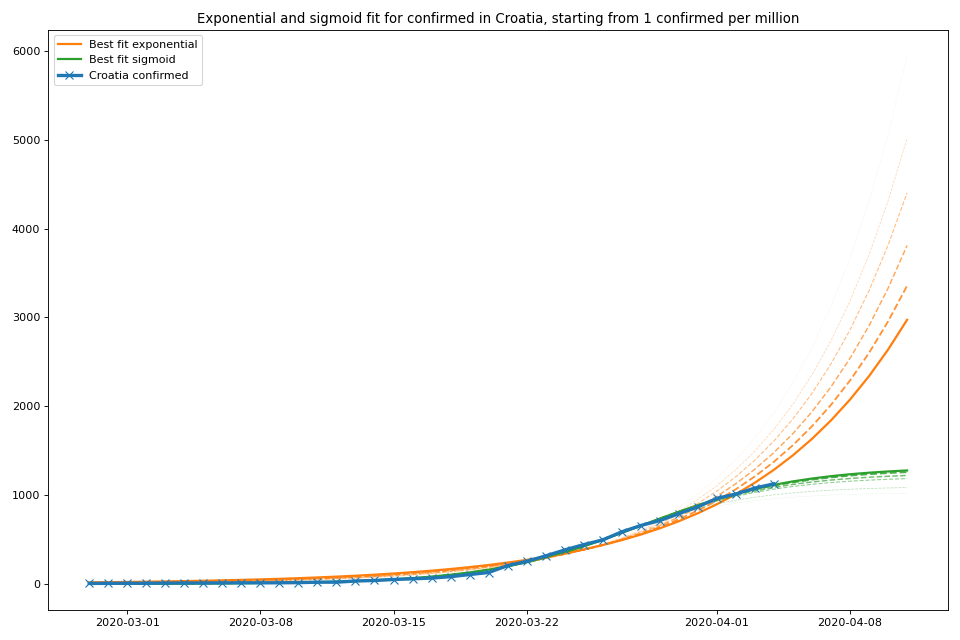

<IPython.core.display.Javascript object>


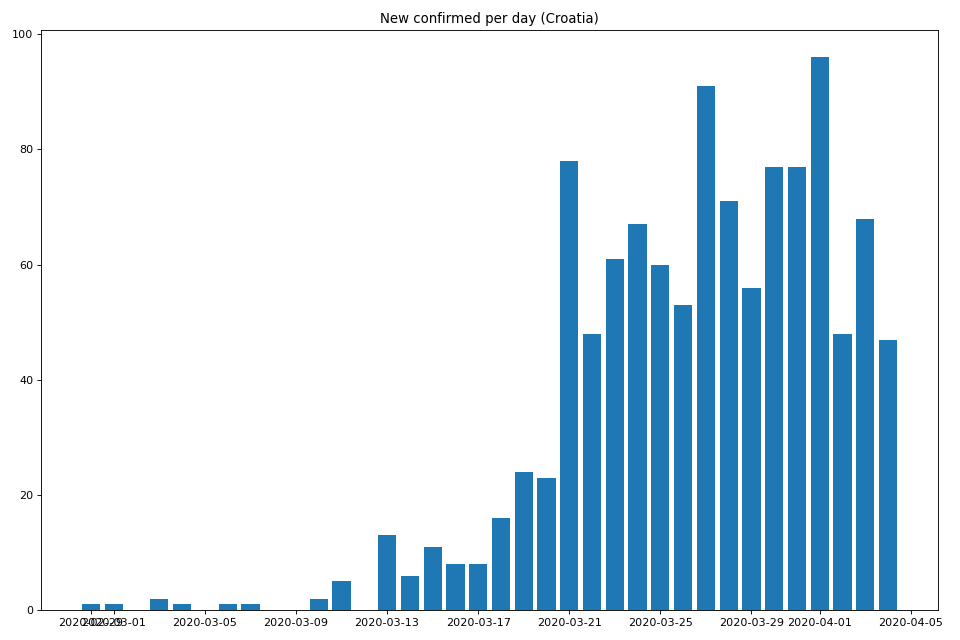

### Dead

Start date 2020-03-19 (1st day with 0.1 dead per million)

Latest number \\(12\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


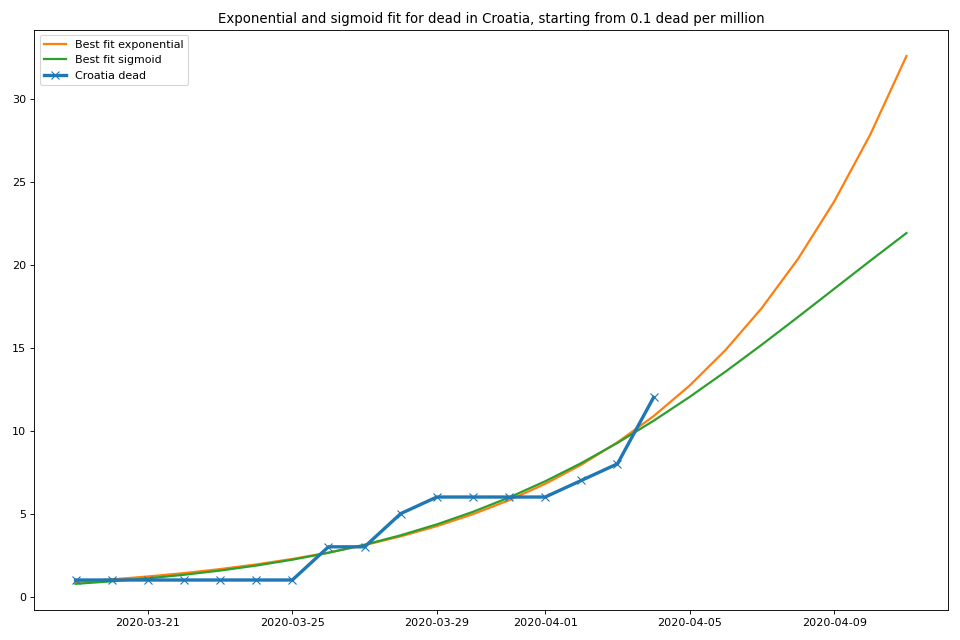

<IPython.core.display.Javascript object>


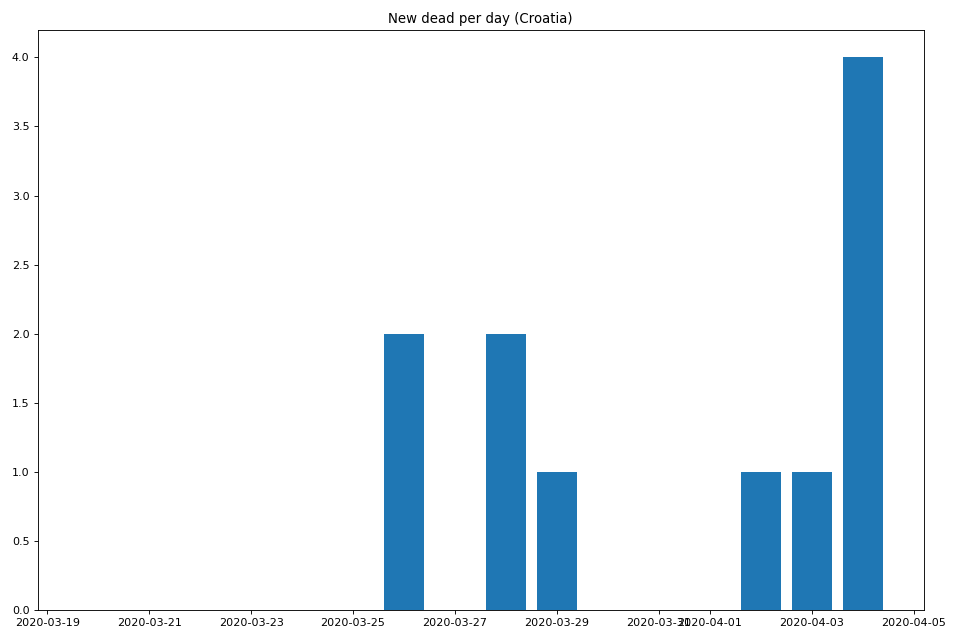

### Active

Start date 2020-02-28 (1st day with 1 active per million)

Latest number \\(995\\) on 2020-04-04

<IPython.core.display.Javascript object>


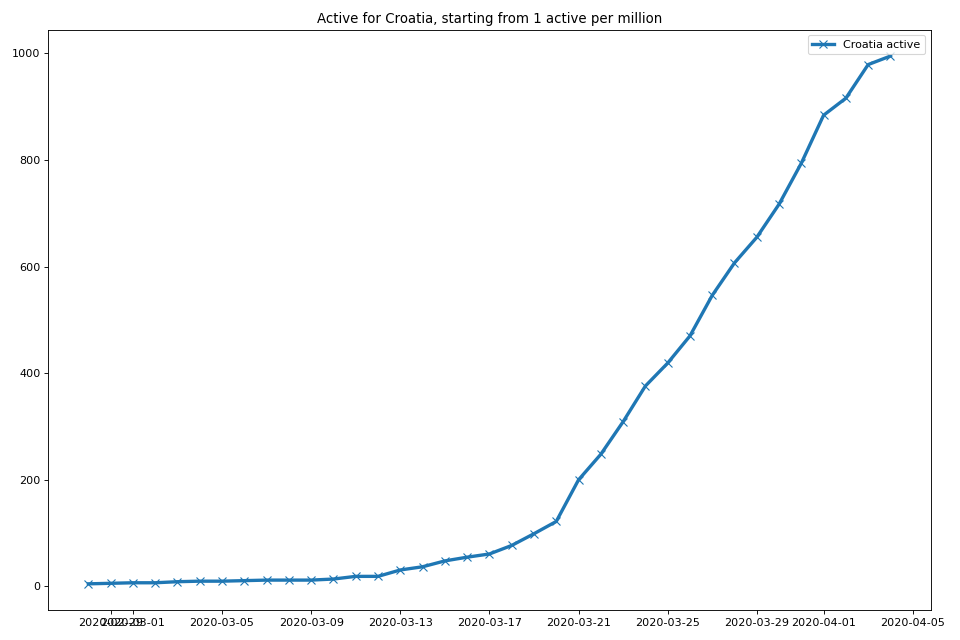

<IPython.core.display.Javascript object>


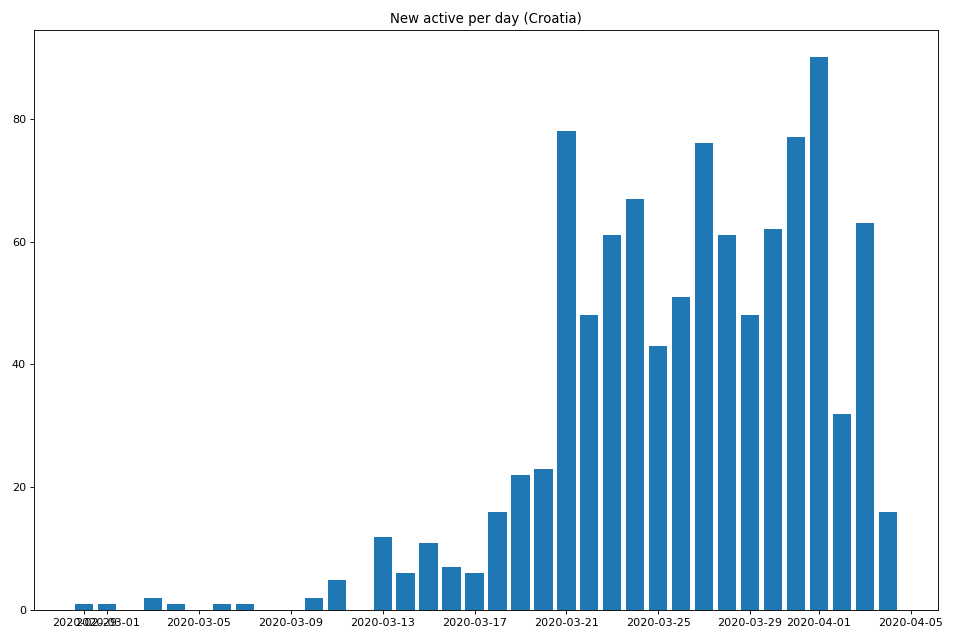

## Switzerland

### Confirmed

Start date 2020-02-29 (1st day with 1 confirmed per million)

Latest number \\(20,505\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


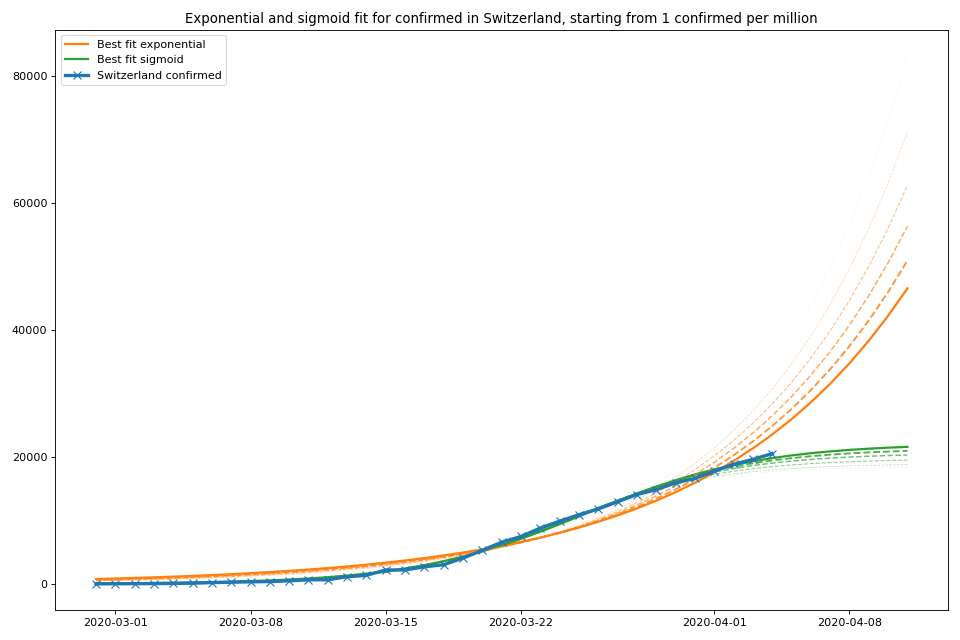

<IPython.core.display.Javascript object>


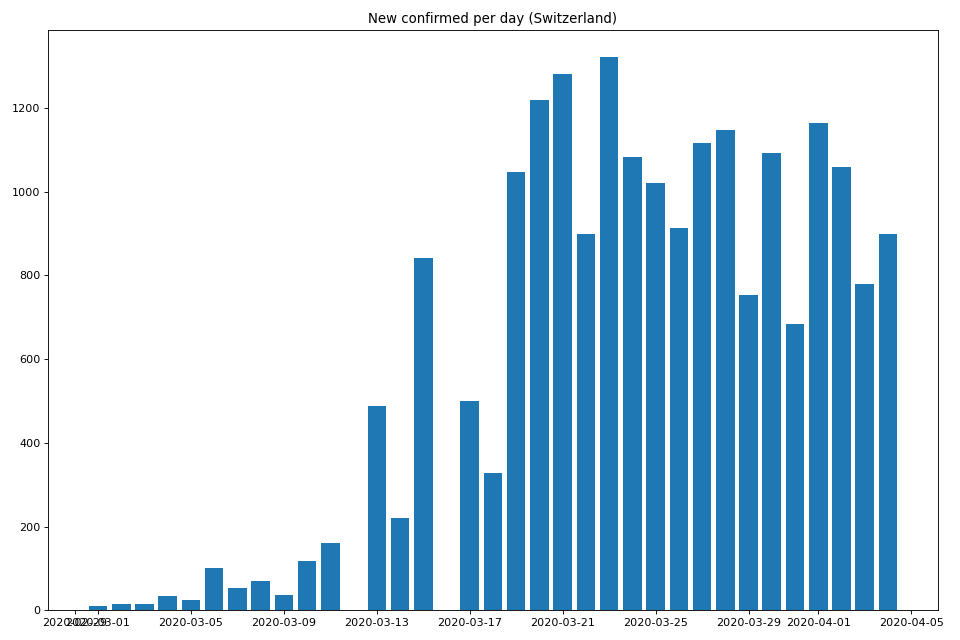

### Dead

Start date 2020-03-05 (1st day with 0.1 dead per million)

Latest number \\(666\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


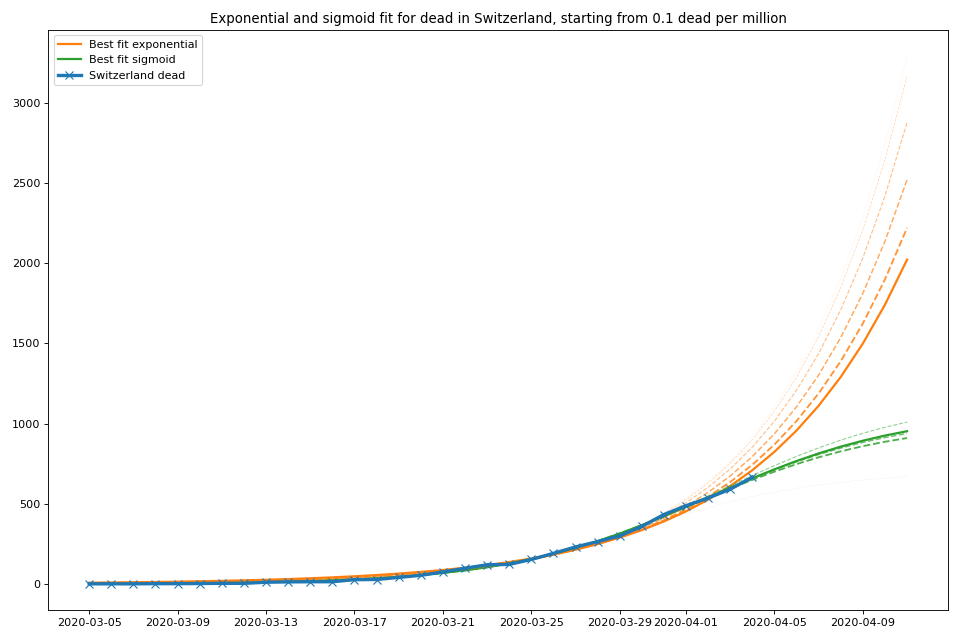

<IPython.core.display.Javascript object>


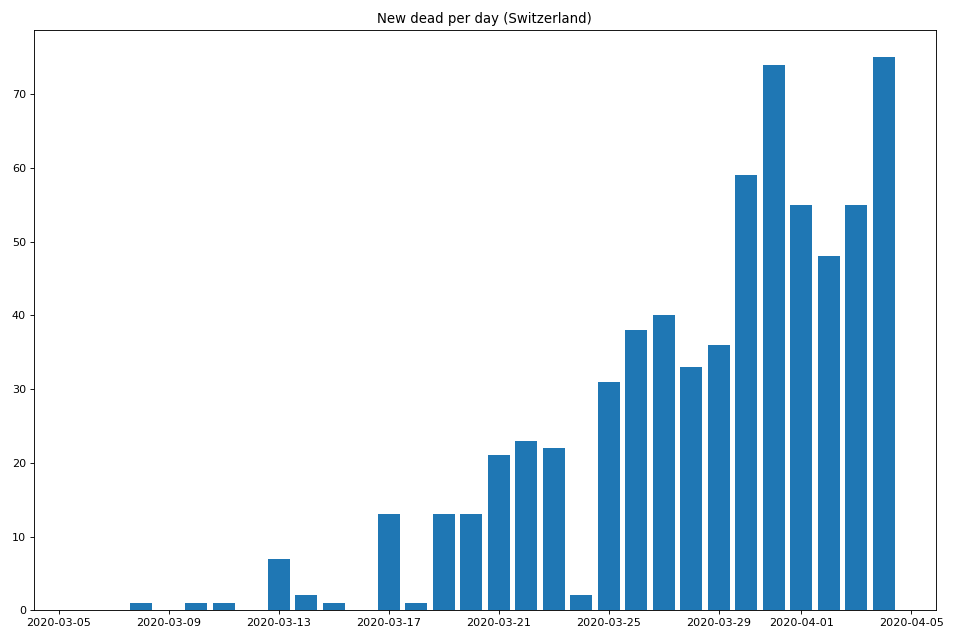

### Active

Start date 2020-02-29 (1st day with 1 active per million)

Latest number \\(13,424\\) on 2020-04-04

<IPython.core.display.Javascript object>


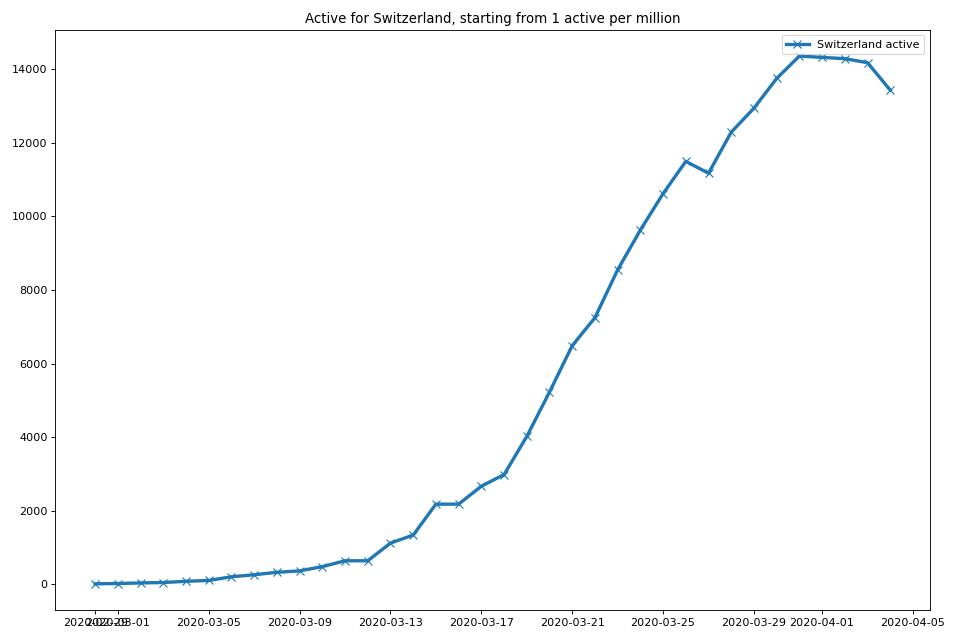

<IPython.core.display.Javascript object>


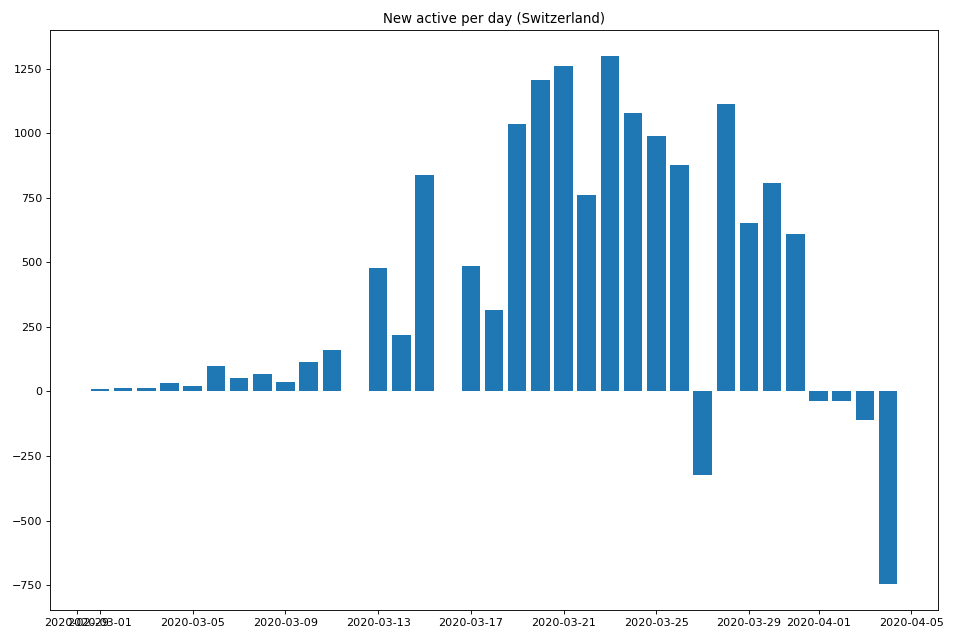

## Italy

### Confirmed

Start date 2020-02-22 (1st day with 1 confirmed per million)

Latest number \\(124,632\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


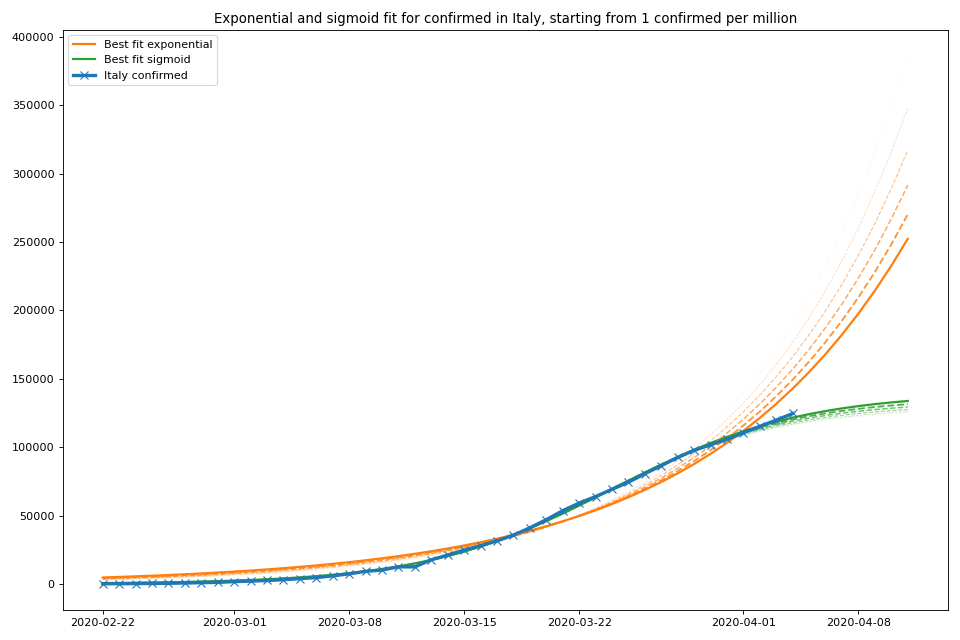

<IPython.core.display.Javascript object>


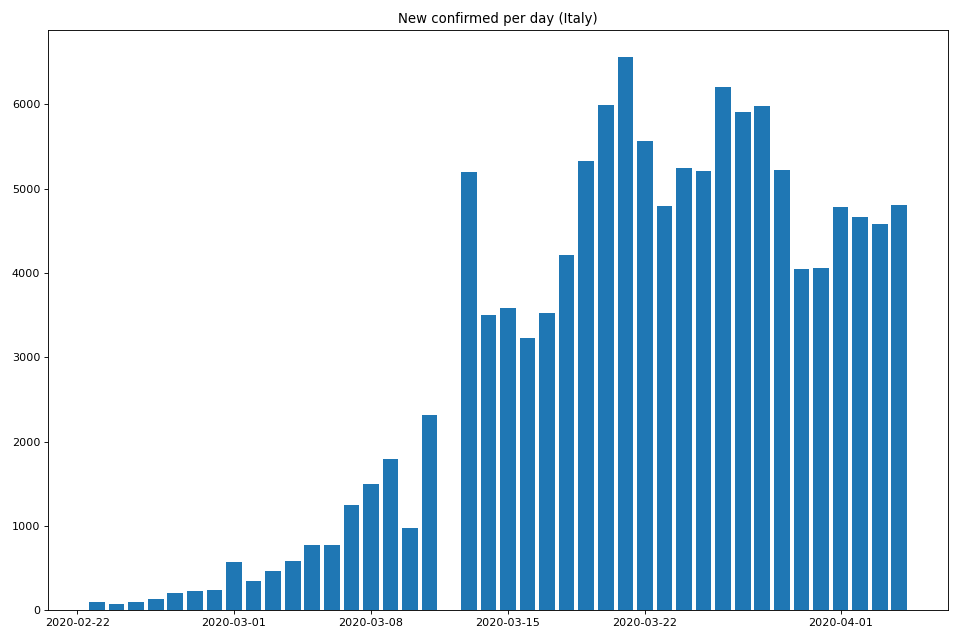

### Dead

Start date 2020-02-24 (1st day with 0.1 dead per million)

Latest number \\(15,362\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


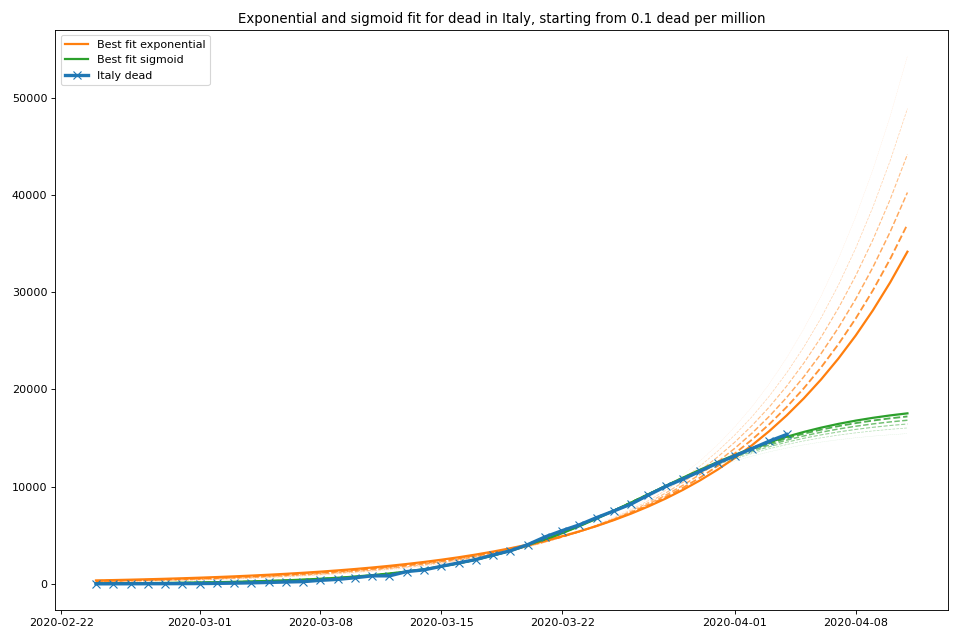

<IPython.core.display.Javascript object>


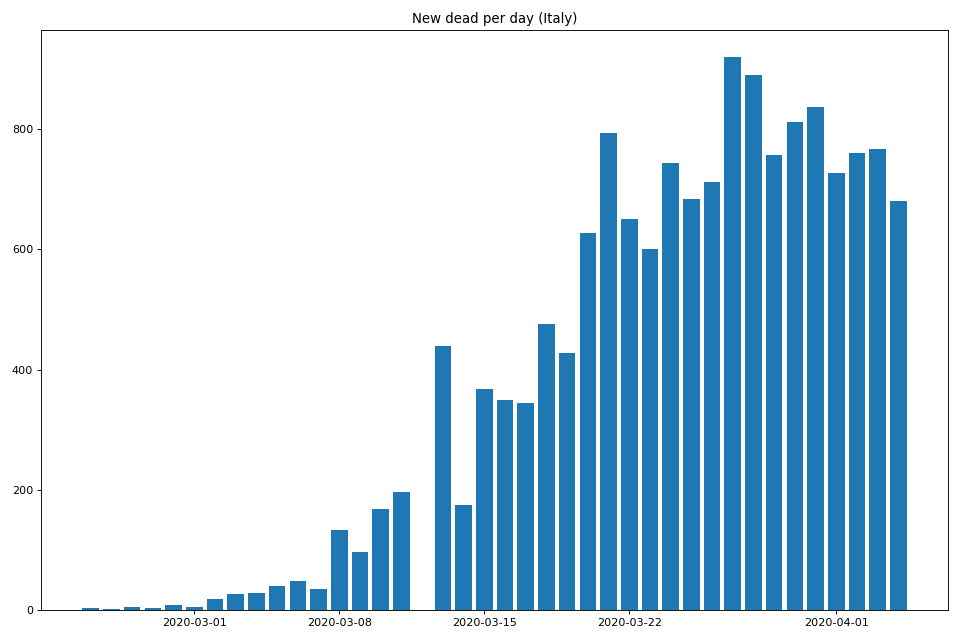

### Active

Start date 2020-02-23 (1st day with 1 active per million)

Latest number \\(88,274\\) on 2020-04-04

<IPython.core.display.Javascript object>


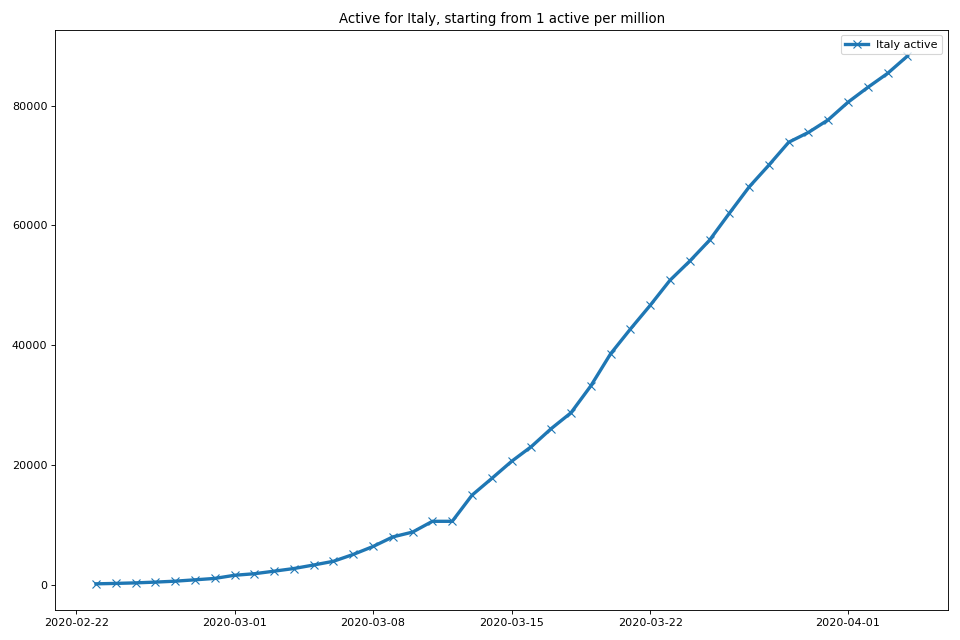

<IPython.core.display.Javascript object>


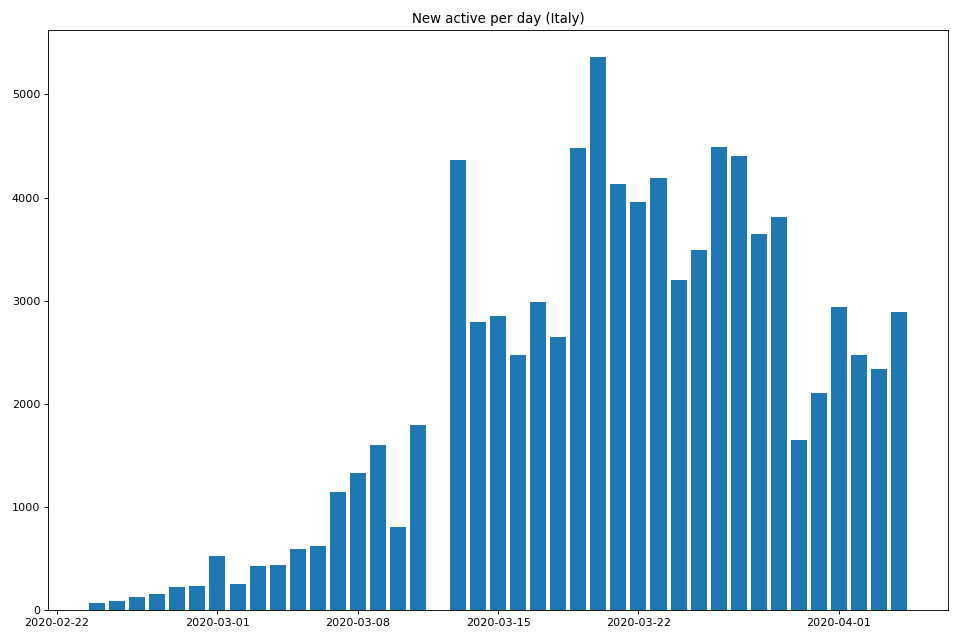

## US

### Confirmed

Start date 2020-03-07 (1st day with 1 confirmed per million)

Latest number \\(308,850\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


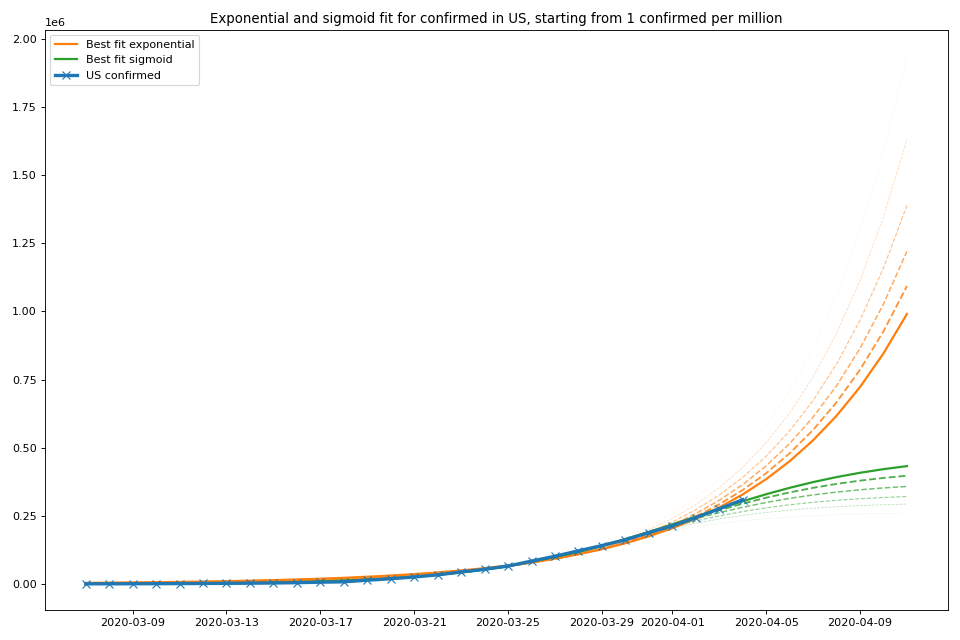

<IPython.core.display.Javascript object>


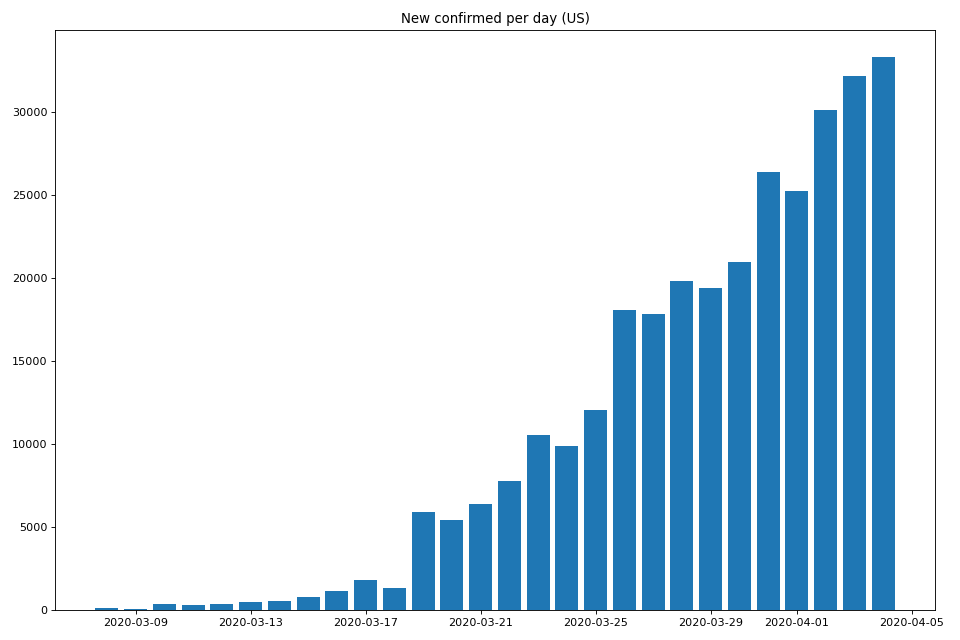

### Dead

Start date 2020-03-11 (1st day with 0.1 dead per million)

Latest number \\(8,407\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


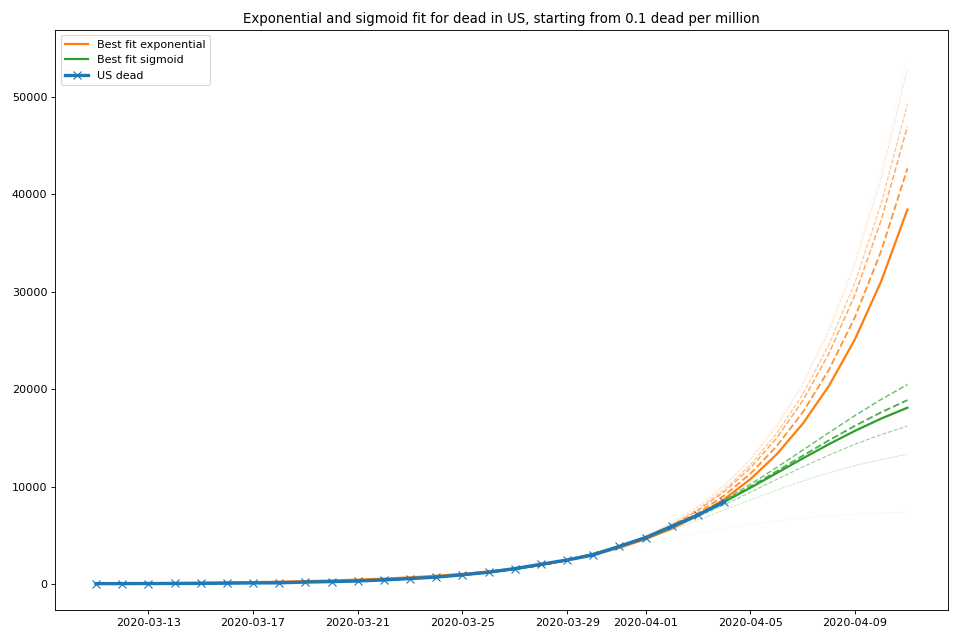

<IPython.core.display.Javascript object>


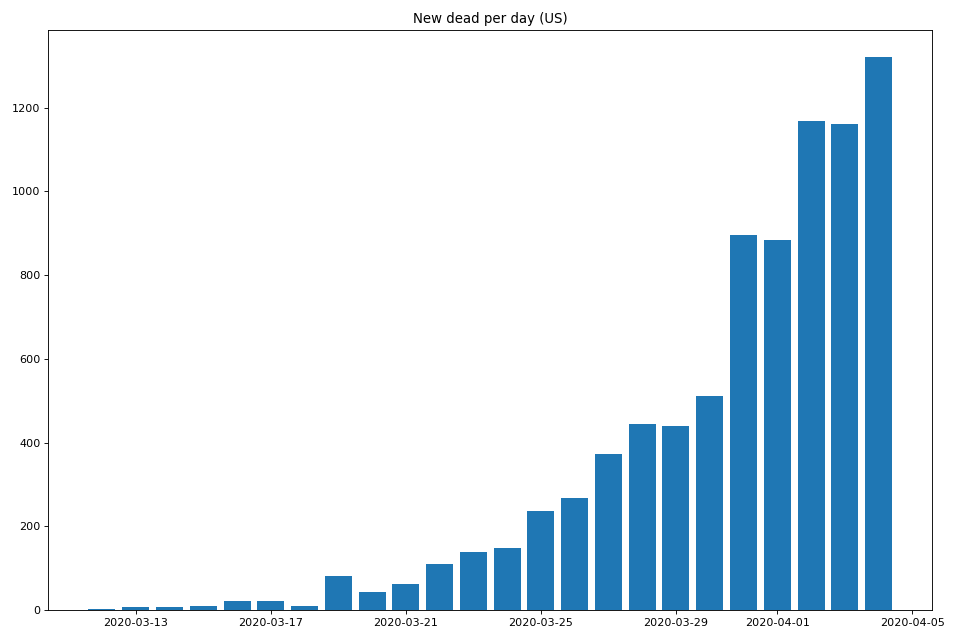

### Active

Start date 2020-03-07 (1st day with 1 active per million)

Latest number \\(285,791\\) on 2020-04-04

<IPython.core.display.Javascript object>


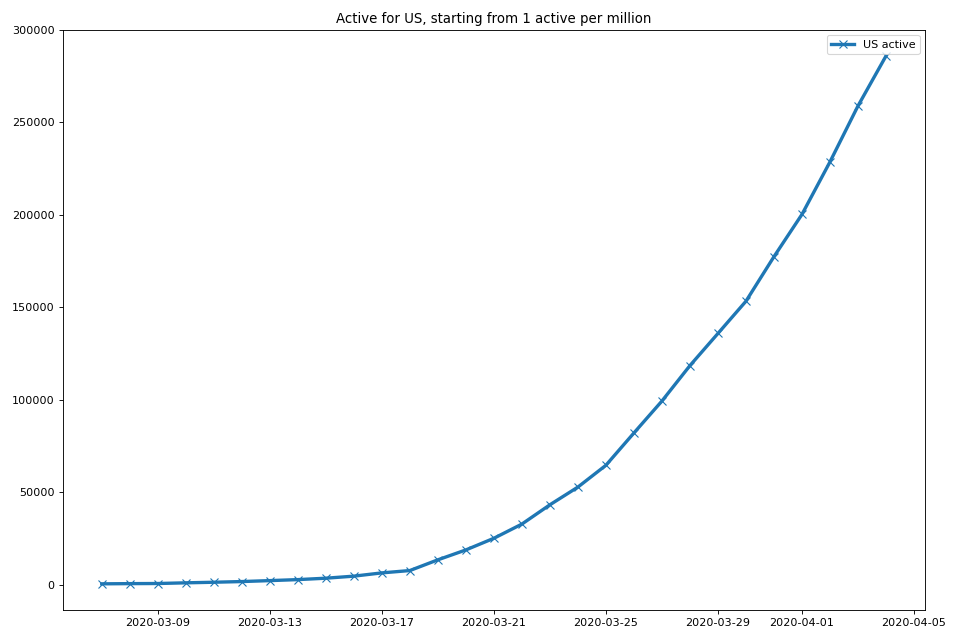

<IPython.core.display.Javascript object>


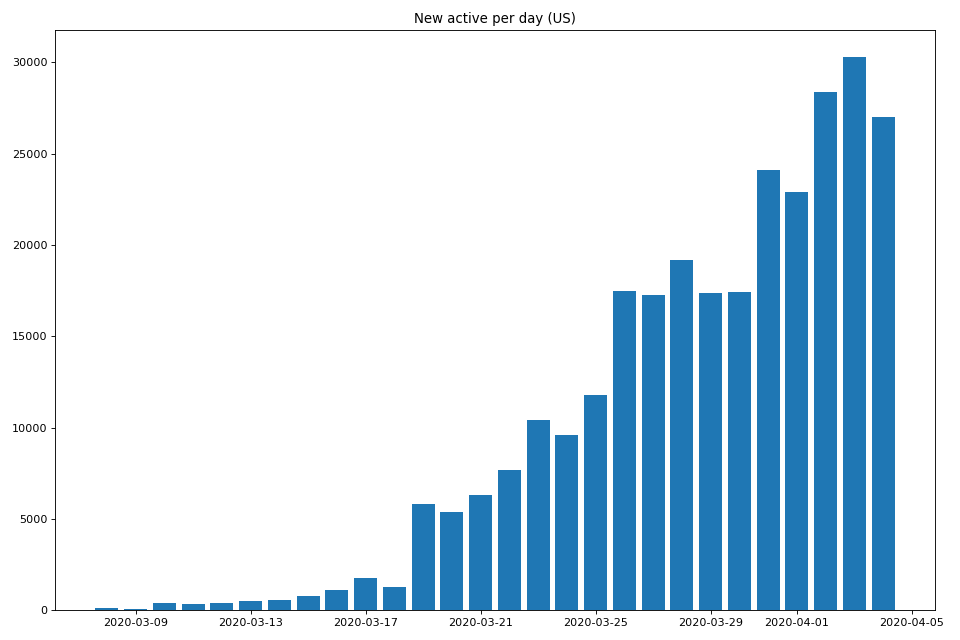

## United Kingdom

### Confirmed

Start date 2020-03-04 (1st day with 1 confirmed per million)

Latest number \\(42,477\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


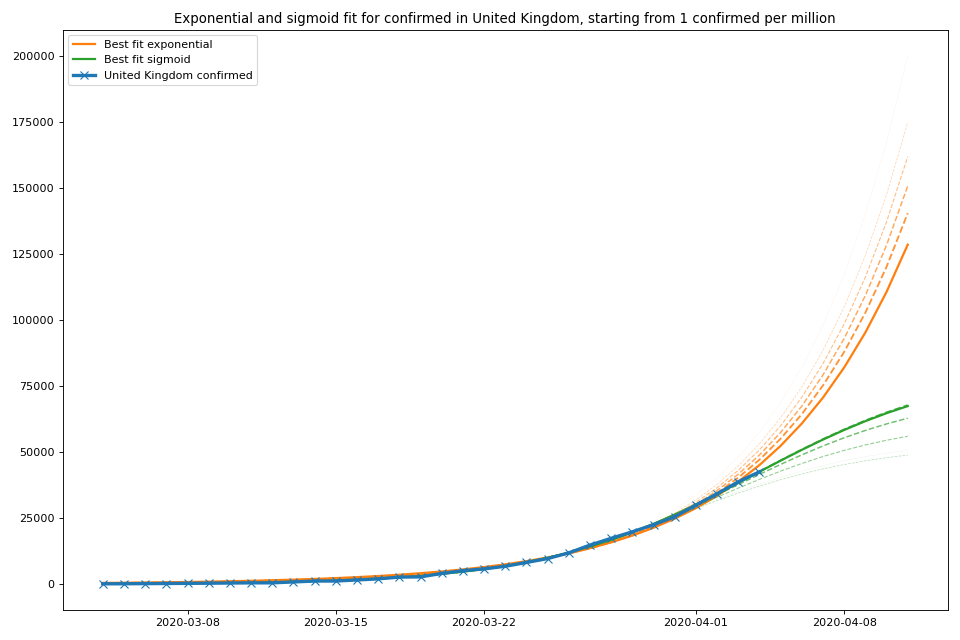

<IPython.core.display.Javascript object>


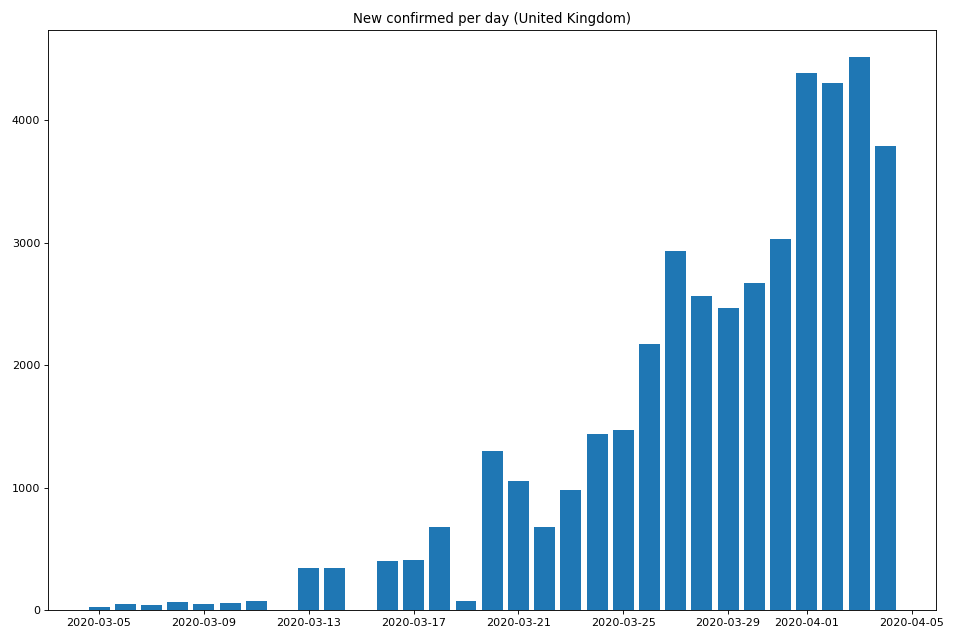

### Dead

Start date 2020-03-11 (1st day with 0.1 dead per million)

Latest number \\(4,320\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


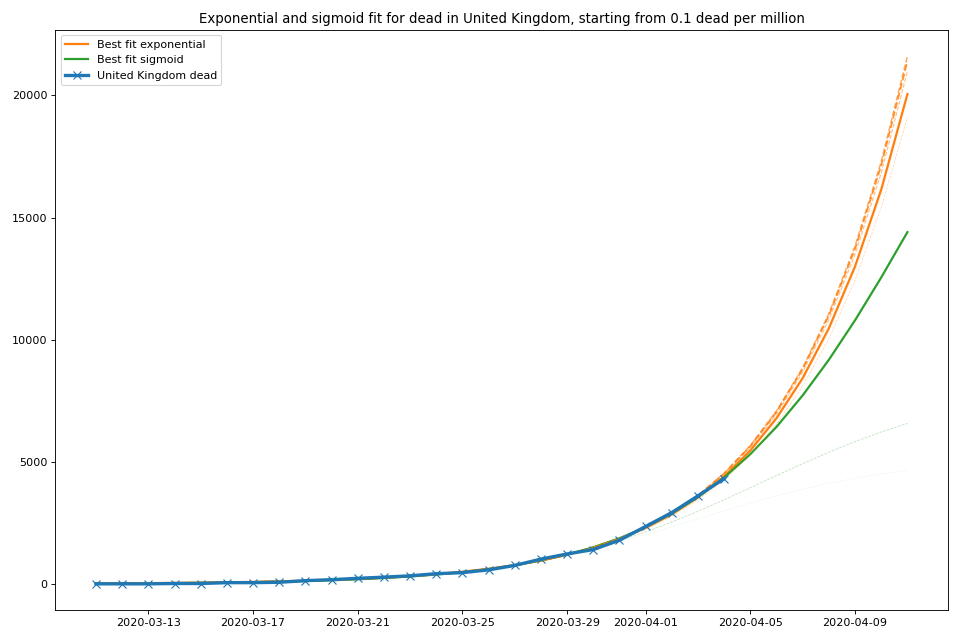

<IPython.core.display.Javascript object>


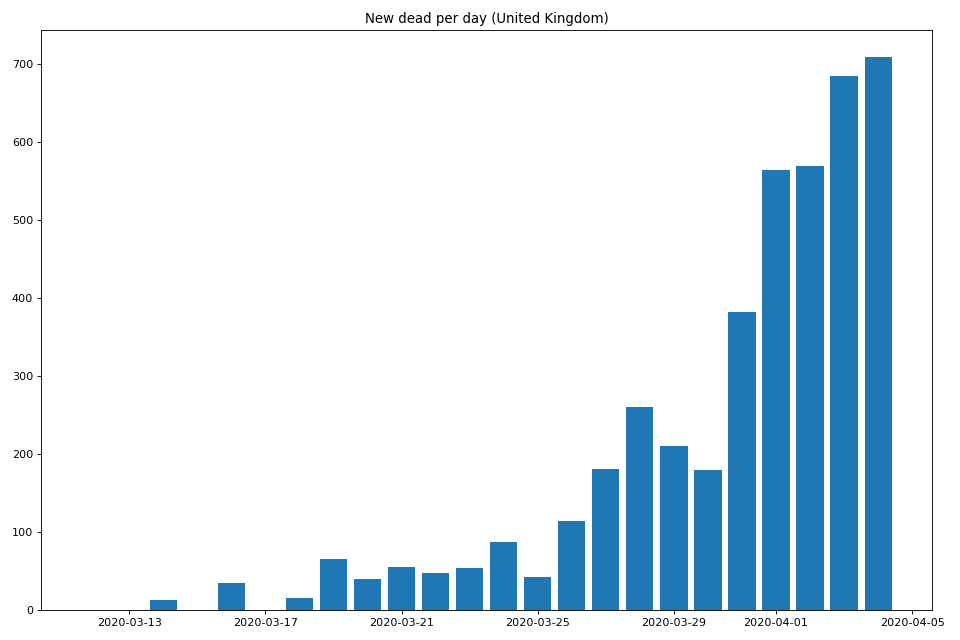

### Active

Start date 2020-03-04 (1st day with 1 active per million)

Latest number \\(37,942\\) on 2020-04-04

<IPython.core.display.Javascript object>


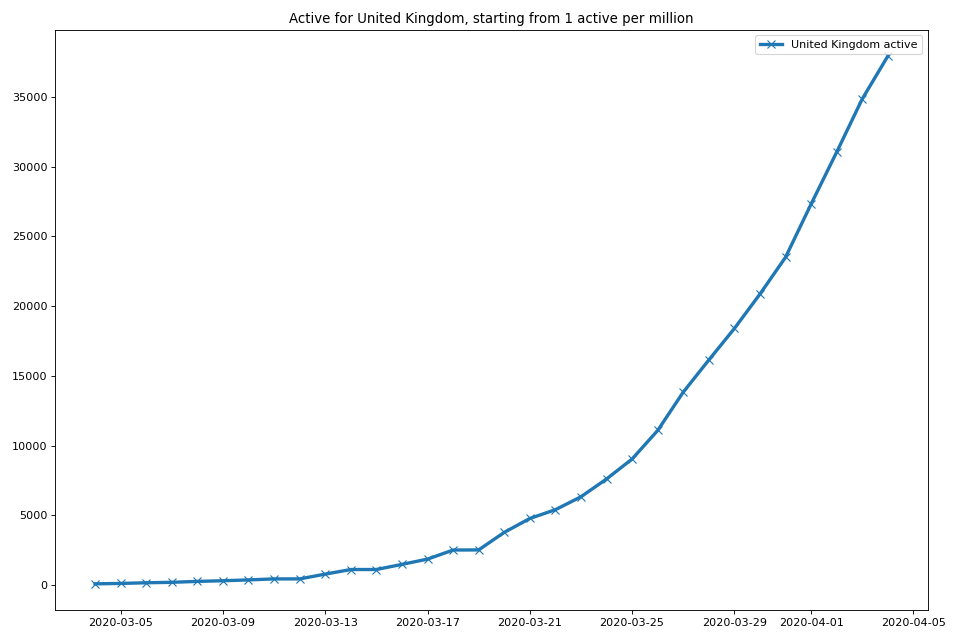

<IPython.core.display.Javascript object>


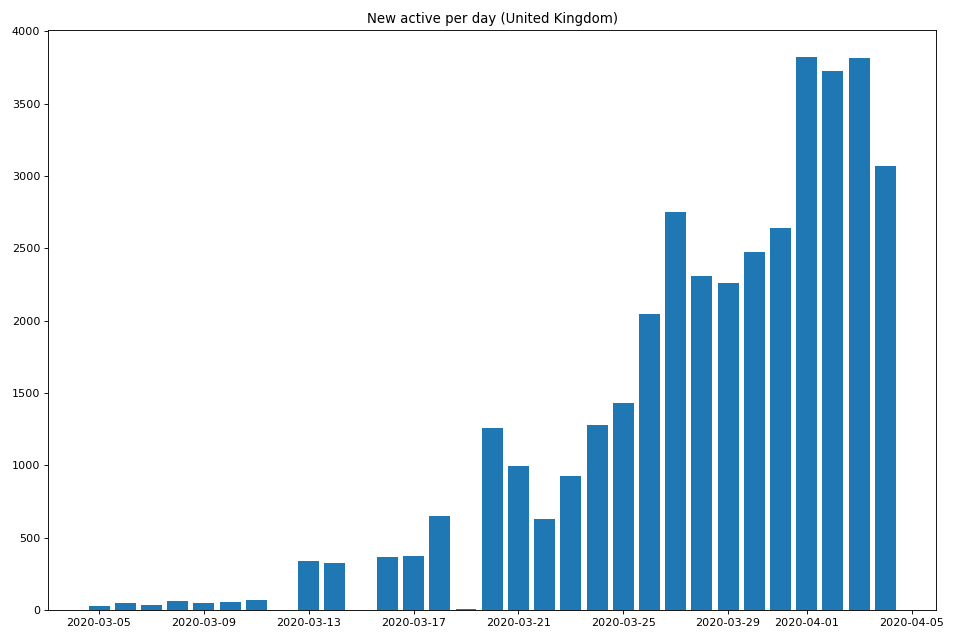

## Sweden

### Confirmed

Start date 2020-02-29 (1st day with 1 confirmed per million)

Latest number \\(6,443\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


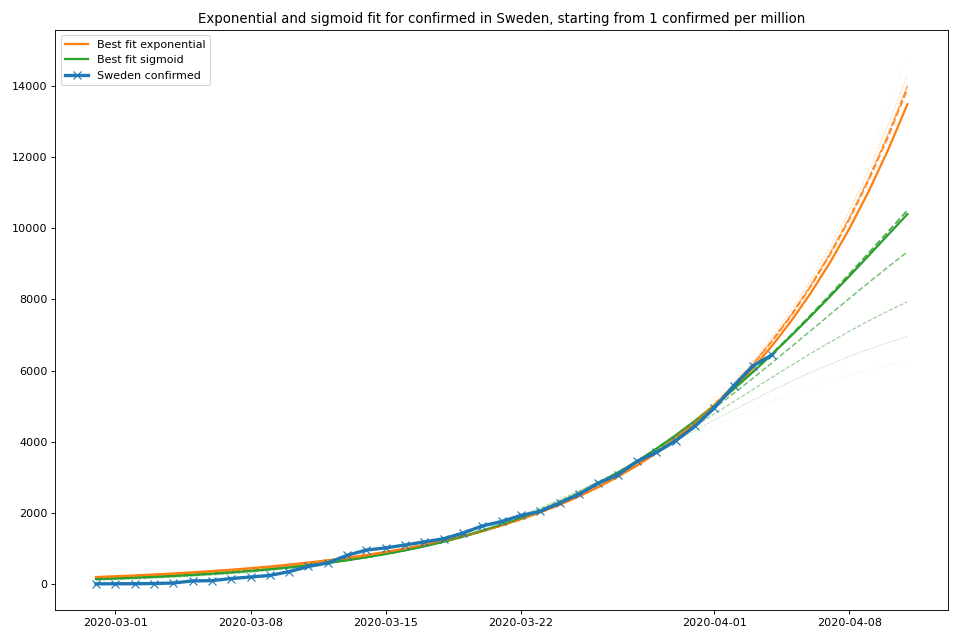

<IPython.core.display.Javascript object>


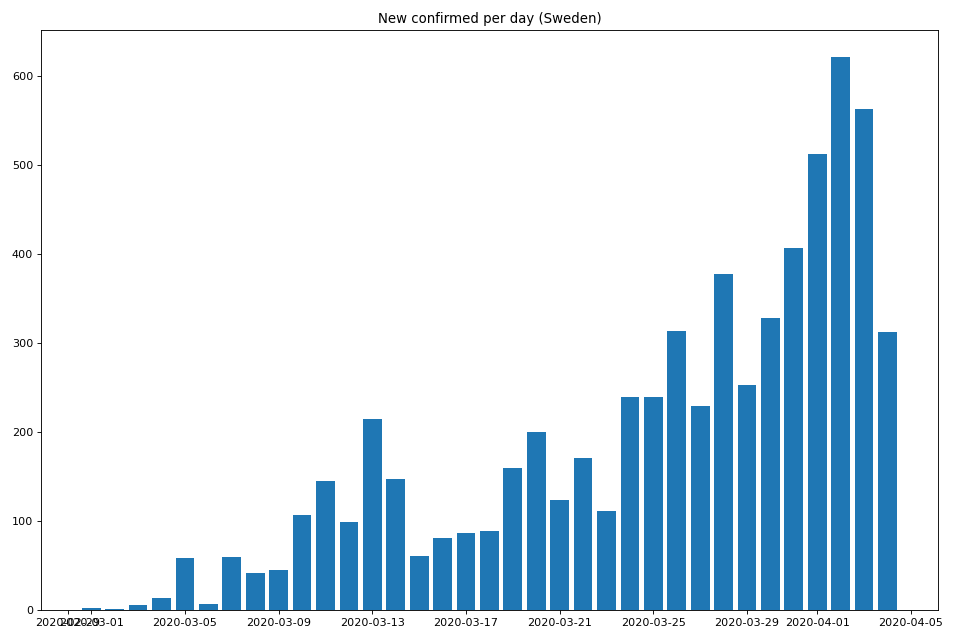

### Dead

Start date 2020-03-14 (1st day with 0.1 dead per million)

Latest number \\(373\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


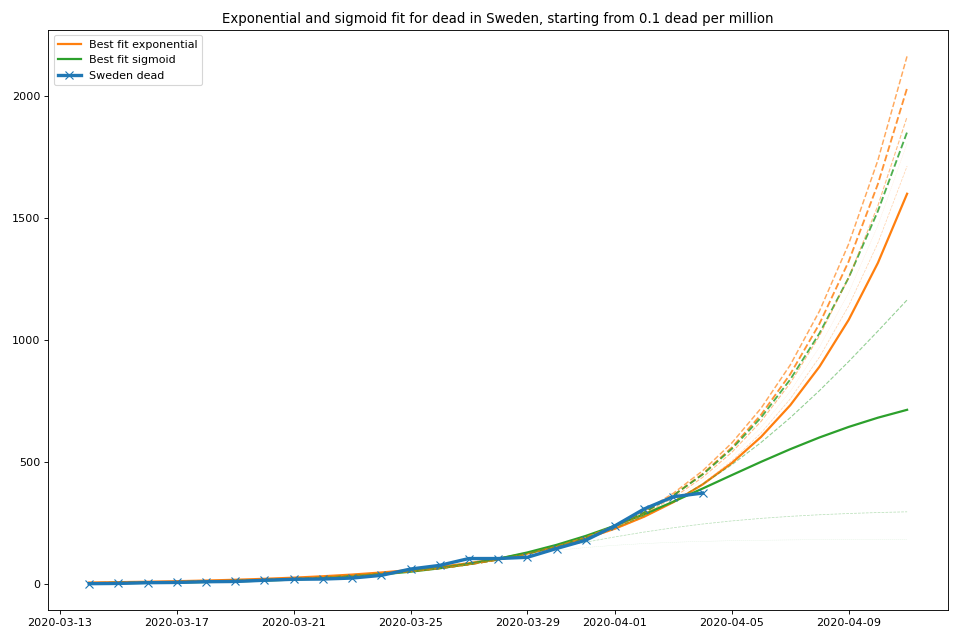

<IPython.core.display.Javascript object>


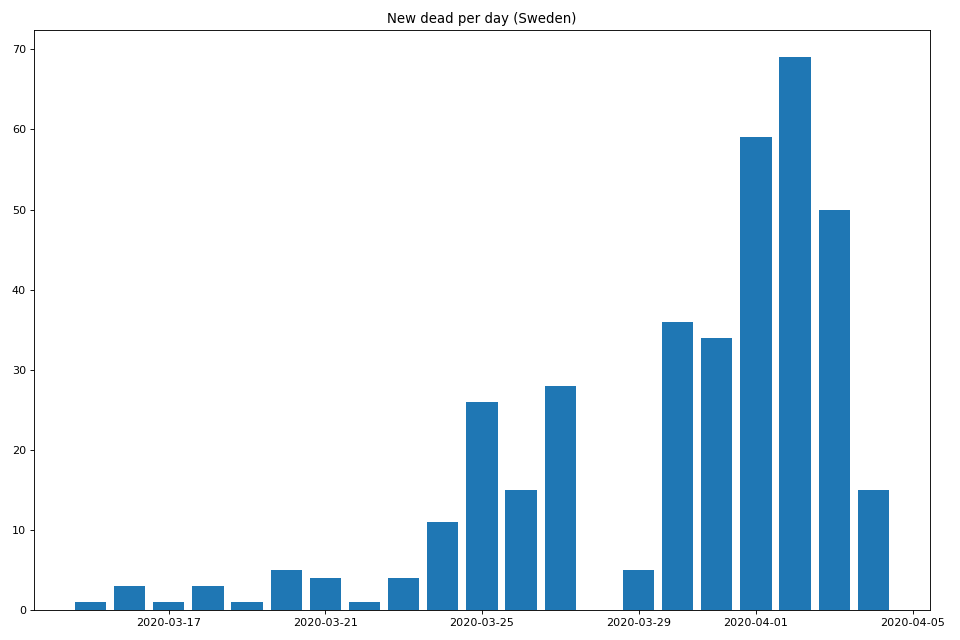

### Active

Start date 2020-02-29 (1st day with 1 active per million)

Latest number \\(5,865\\) on 2020-04-04

<IPython.core.display.Javascript object>


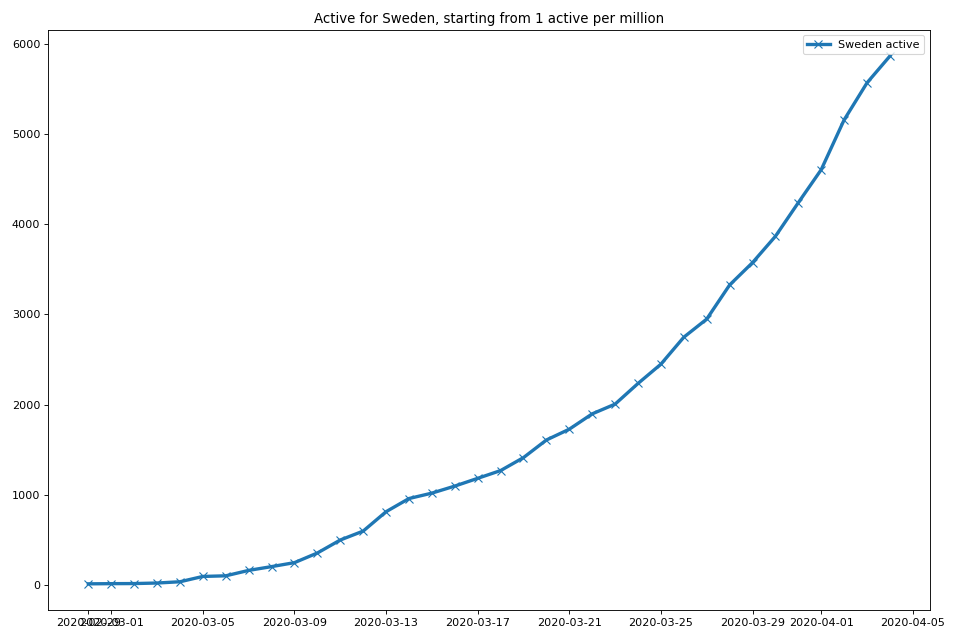

<IPython.core.display.Javascript object>


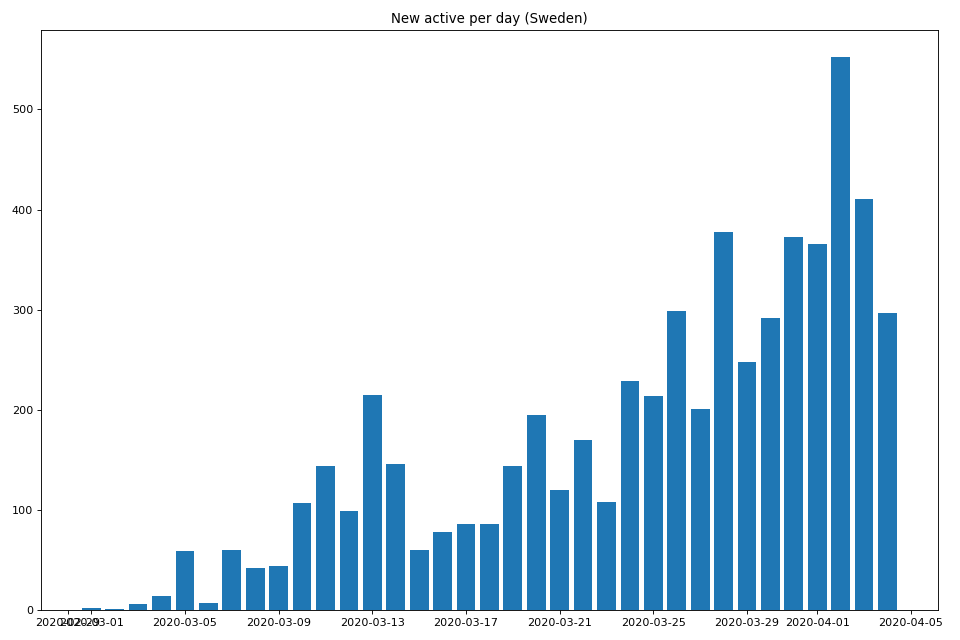

In [3]:
for country in countries_to_plot:
    country_deep_dive(country)

# Recovering countries that had over 300 active cases at peak

China recovered 96%
Korea, South recovered 52%


## China

### Confirmed

Start date 2020-01-26 (1st day with 1 confirmed per million)

Latest number \\(82,543\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


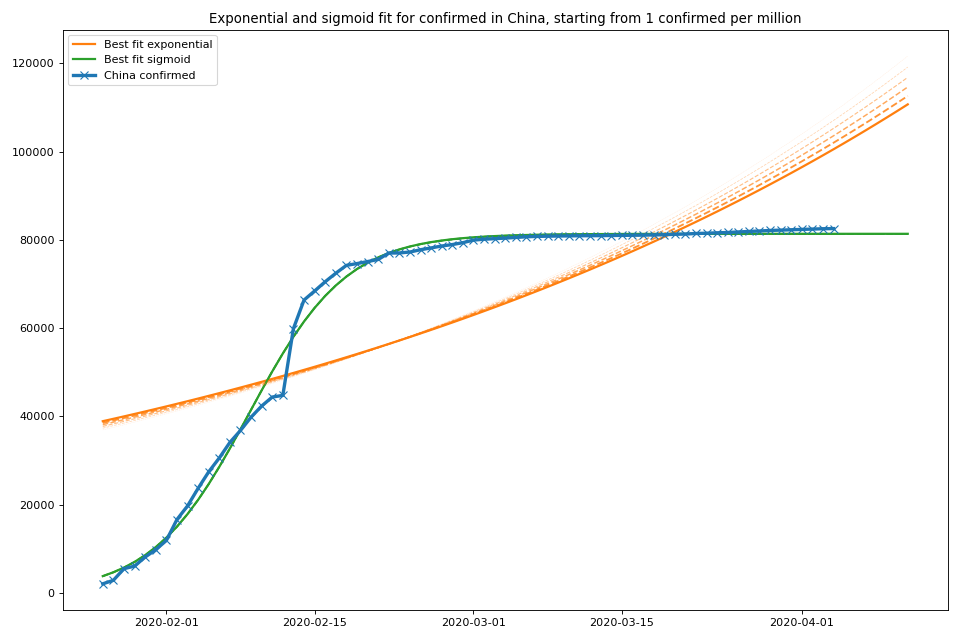

<IPython.core.display.Javascript object>


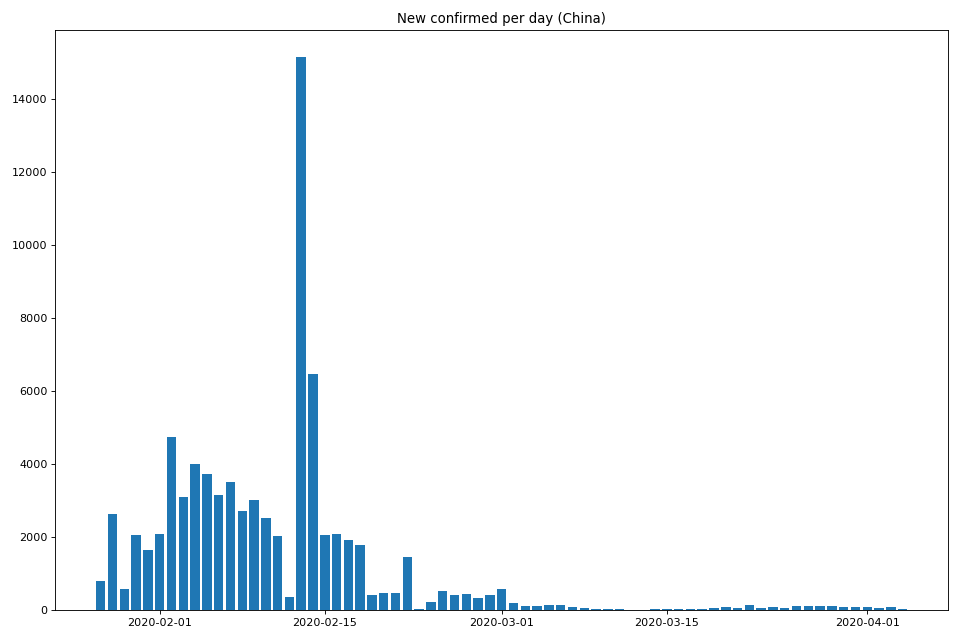

### Dead

Start date 2020-01-30 (1st day with 0.1 dead per million)

Latest number \\(3,330\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


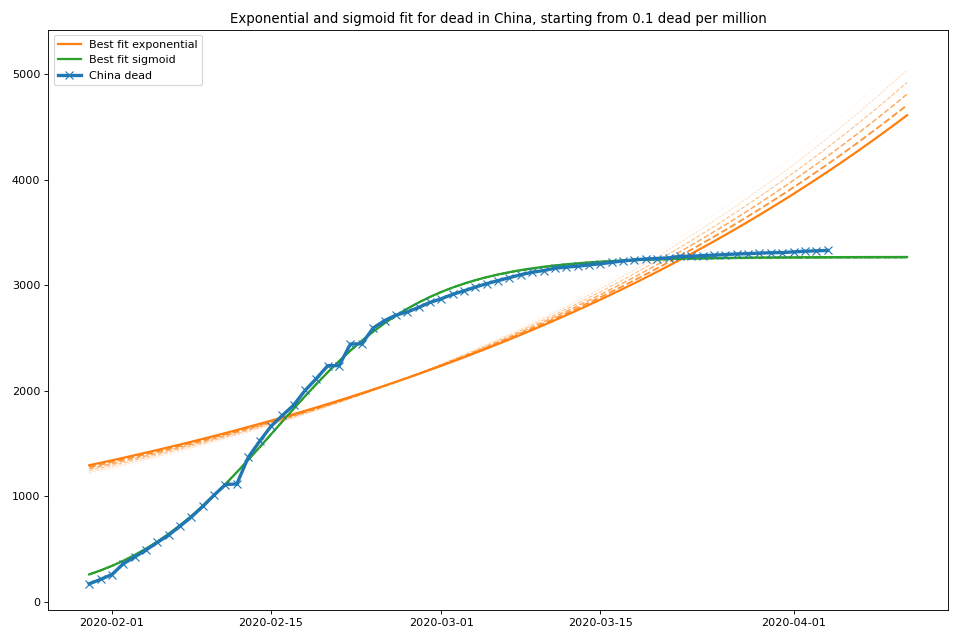

<IPython.core.display.Javascript object>


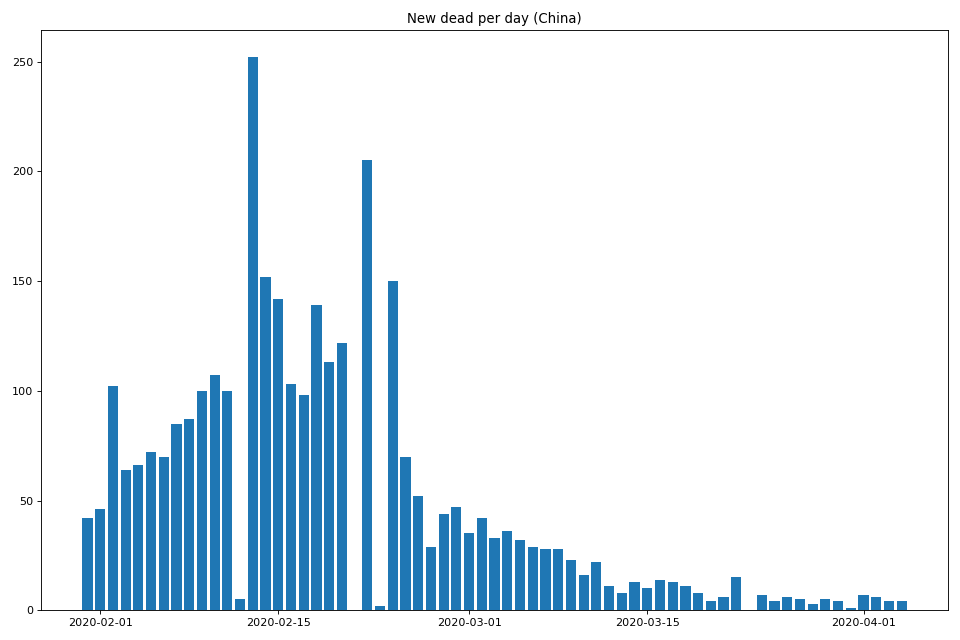

### Active

Start date 2020-01-26 (1st day with 1 active per million)

Latest number \\(2,267\\) on 2020-04-04

<IPython.core.display.Javascript object>


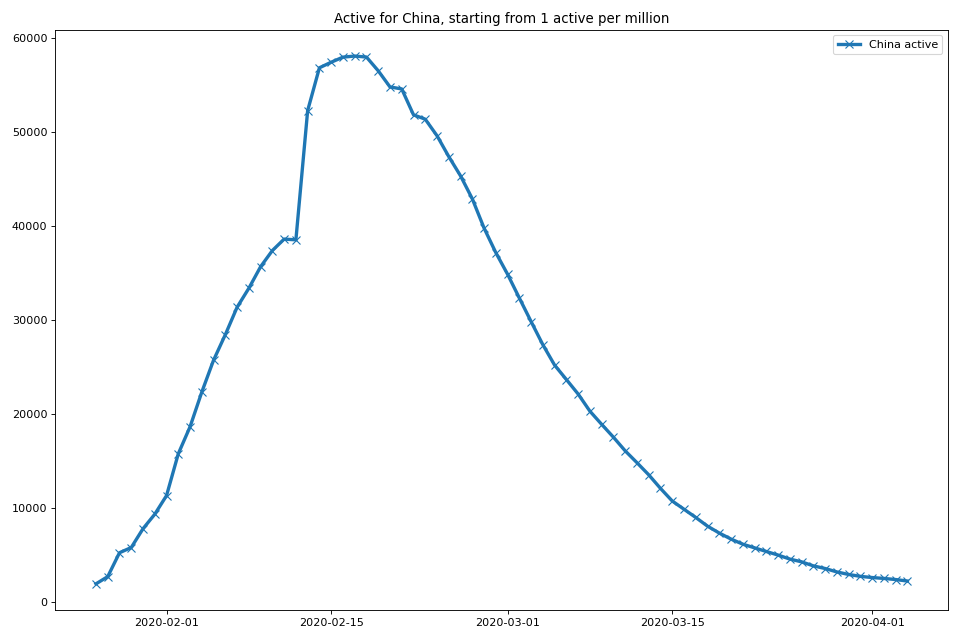

<IPython.core.display.Javascript object>


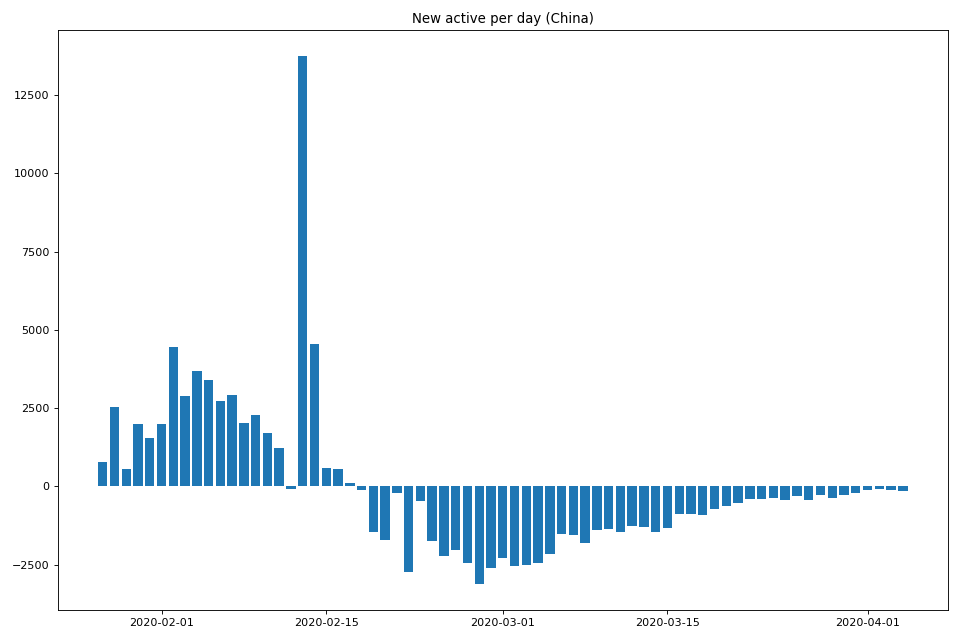

## Korea, South

### Confirmed

Start date 2020-02-20 (1st day with 1 confirmed per million)

Latest number \\(10,156\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


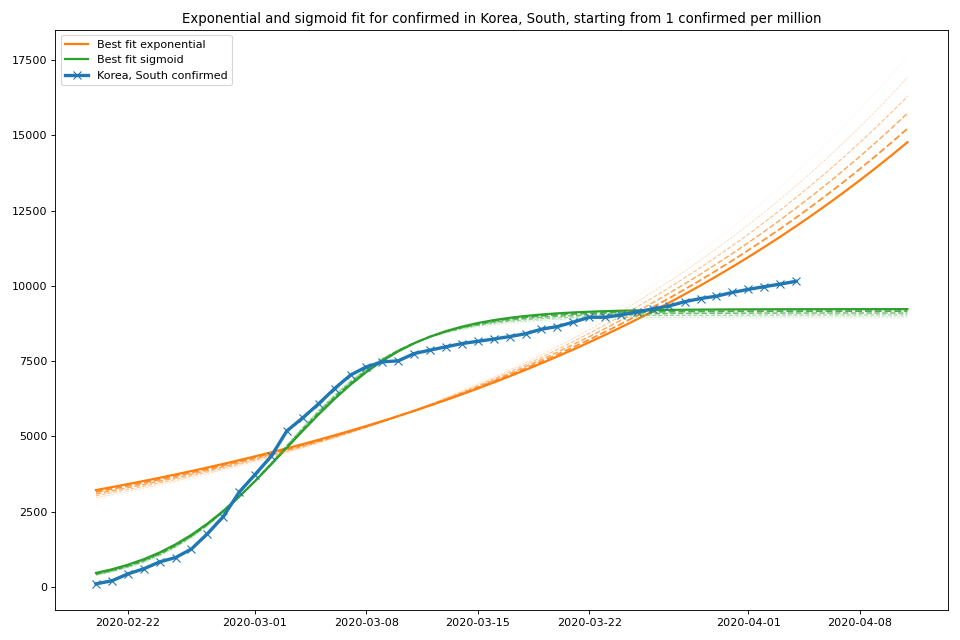

<IPython.core.display.Javascript object>


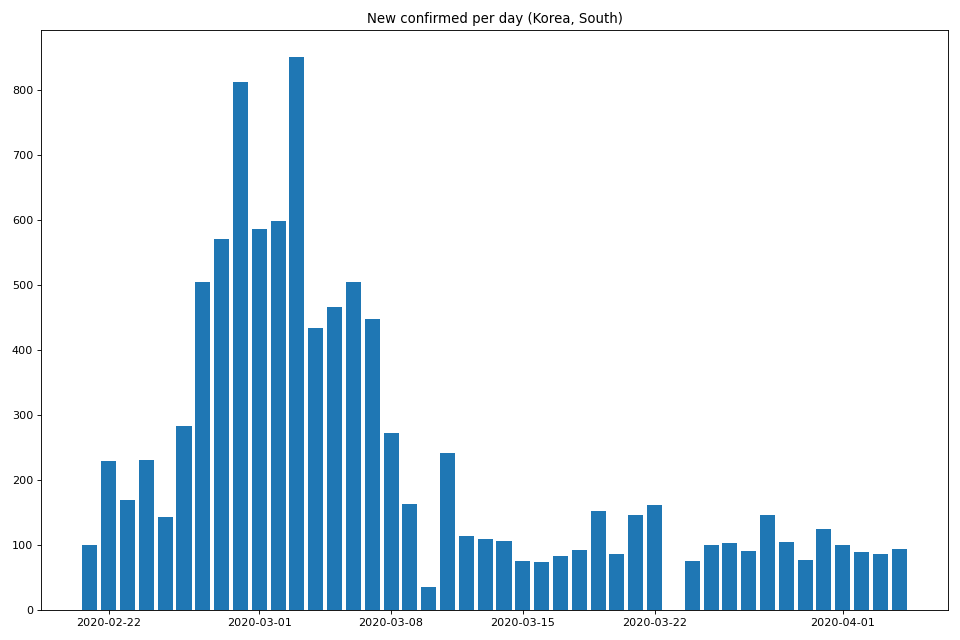

### Dead

Start date 2020-02-23 (1st day with 0.1 dead per million)

Latest number \\(177\\) on 2020-04-04

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


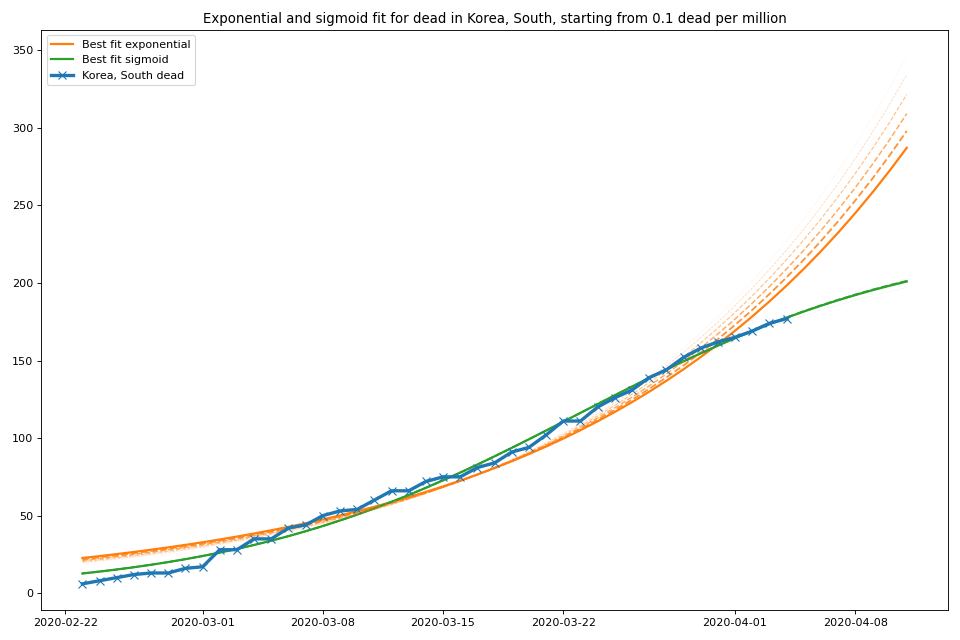

<IPython.core.display.Javascript object>


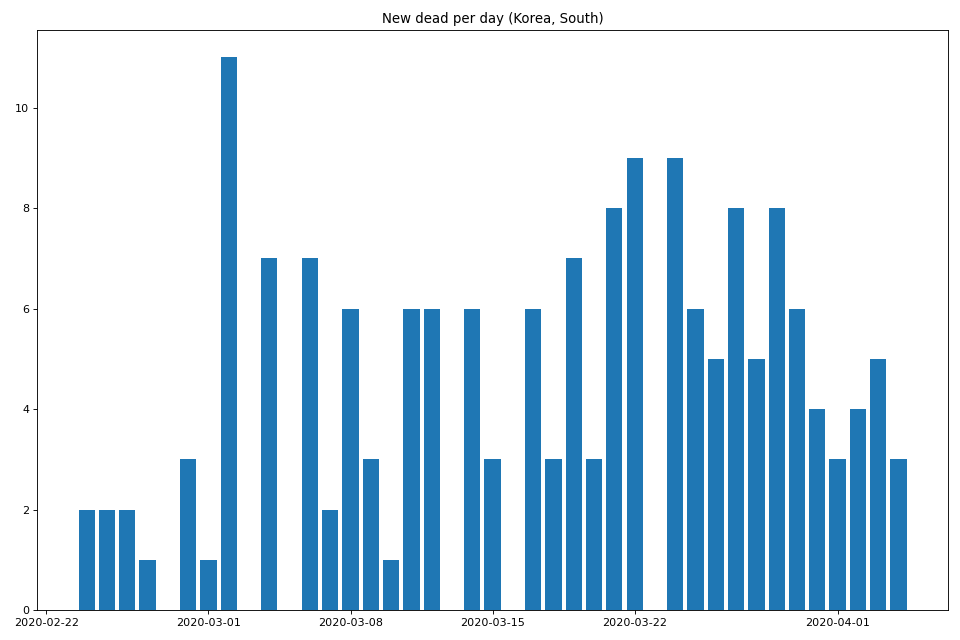

### Active

Start date 2020-02-20 (1st day with 1 active per million)

Latest number \\(3,654\\) on 2020-04-04

<IPython.core.display.Javascript object>


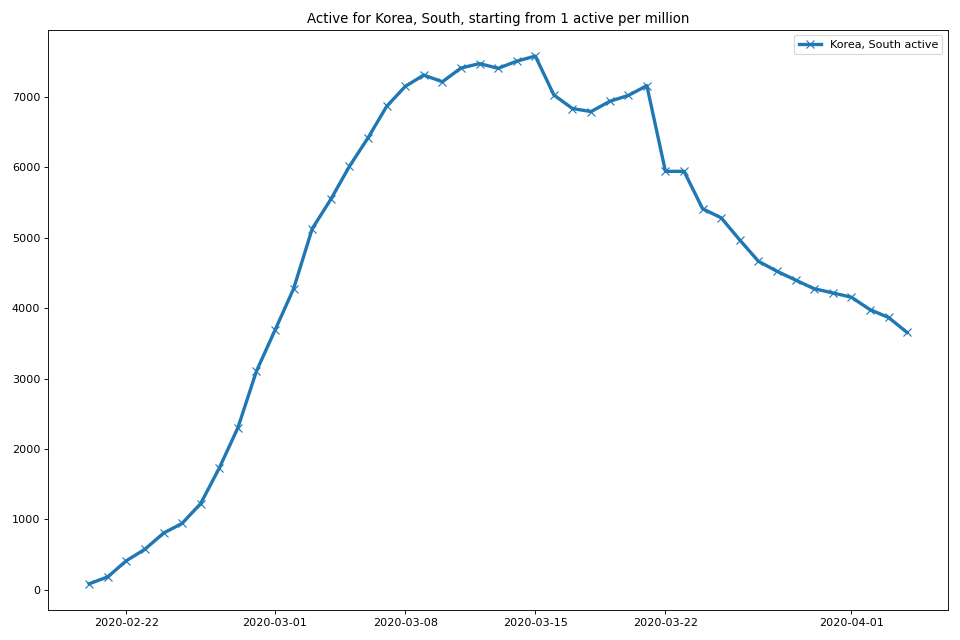

<IPython.core.display.Javascript object>


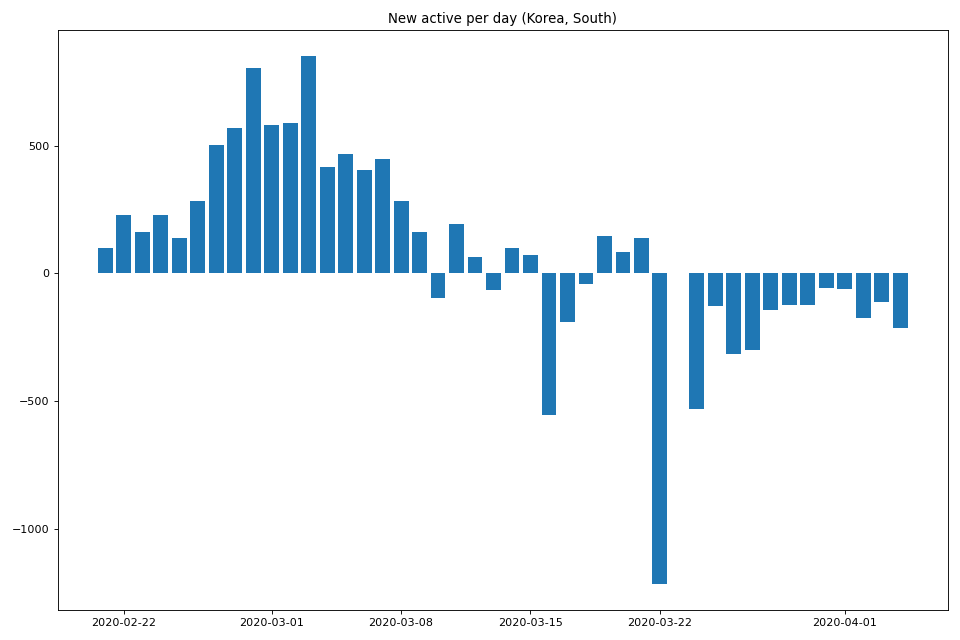

In [4]:
recovering_countries_info = get_recovering_countries_info()
for info in recovering_countries_info:
    print(f'{info[0]} recovered {info[1]:.0f}%')

max_num_to_draw = 4
for info in recovering_countries_info:
    if info[0] not in countries_to_plot:
        country_deep_dive(info[0])
        max_num_to_draw -= 1
        if max_num_to_draw == 0:
            break

# Cross-country comparison over absolute dates

## Confirmed

<IPython.core.display.Javascript object>


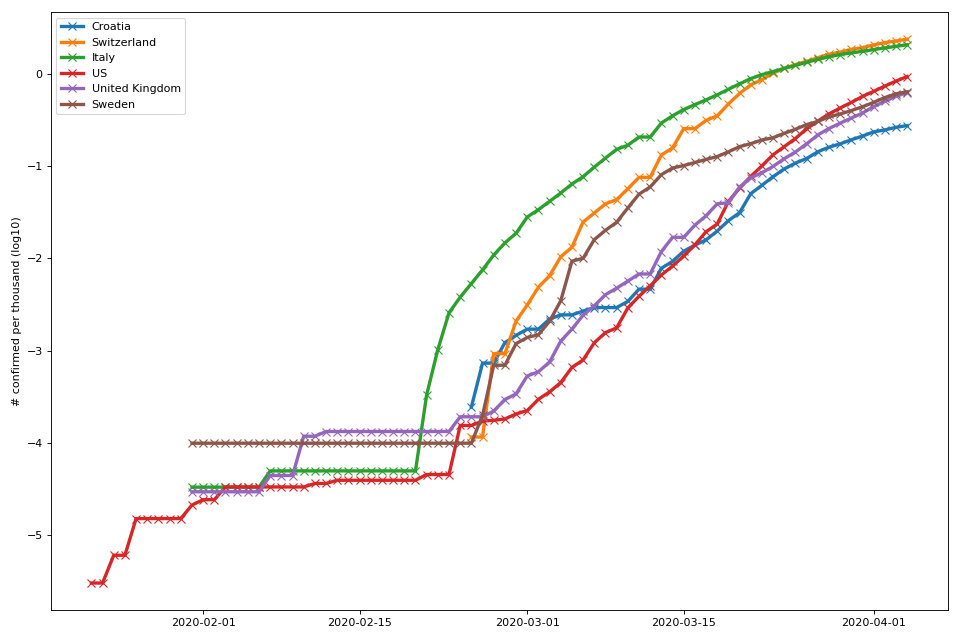

## Dead

<IPython.core.display.Javascript object>


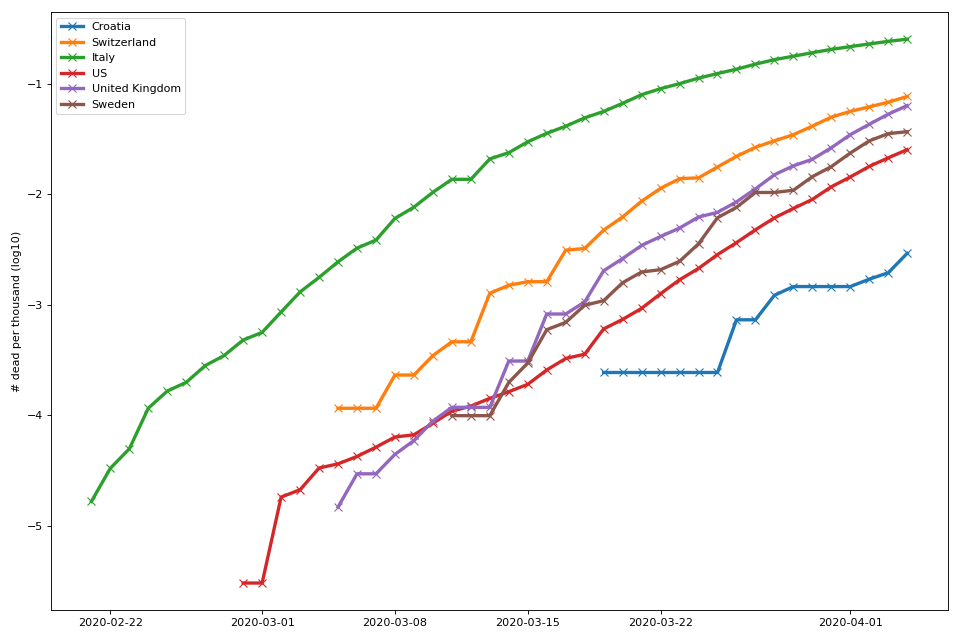

In [5]:
for series in ['confirmed', 'dead']:
    compare_countries_absolute_dates(series)

# Cross-country comparison with approximately aligned start days, and exponential best fit lines

## Confirmed

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


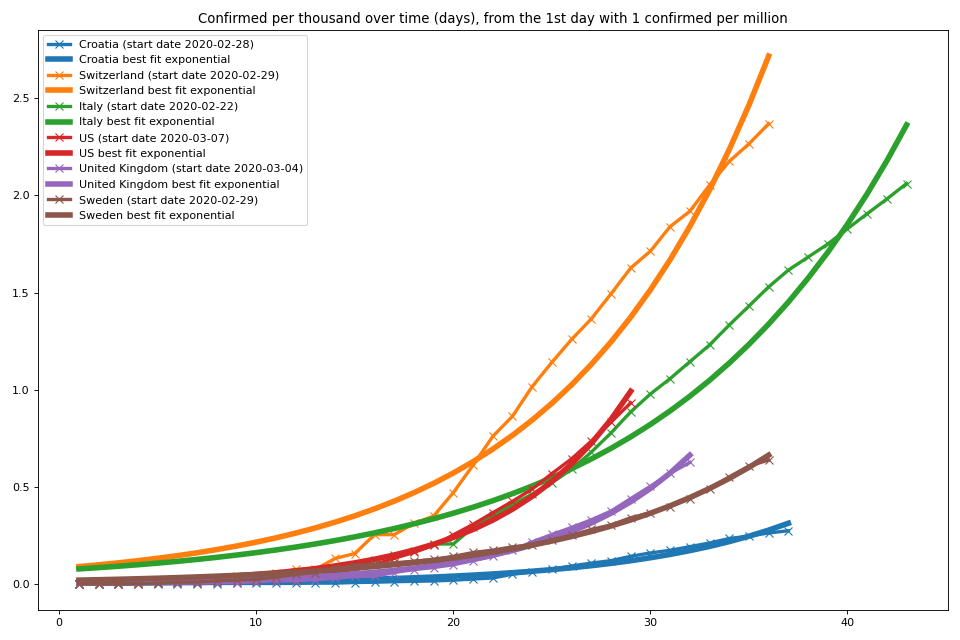

<IPython.core.display.Javascript object>


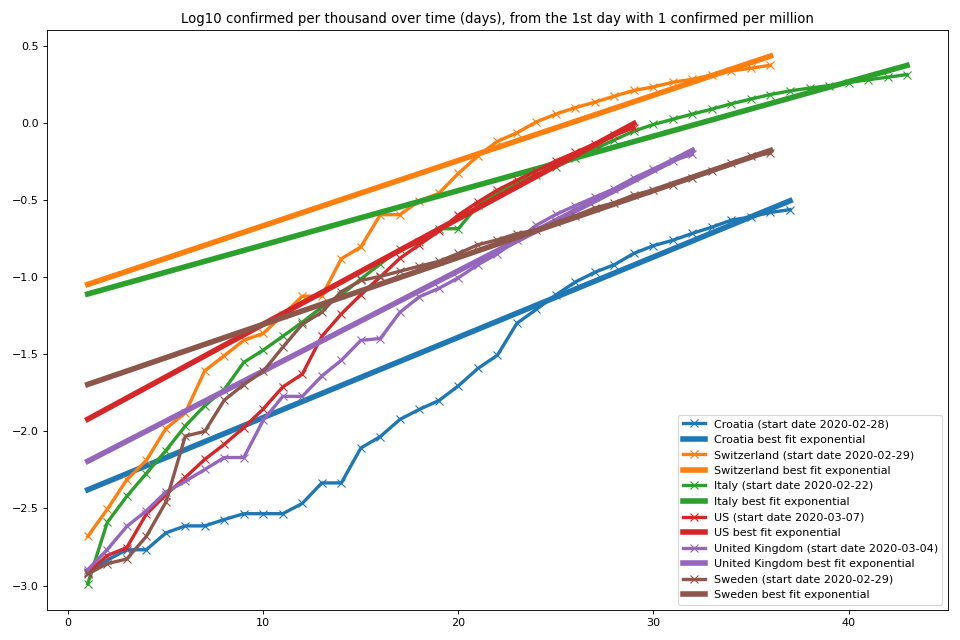

In [6]:
compare_countries_relative_dates('confirmed', start_info=(0.001, '1 confirmed per million'))

## Dead

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


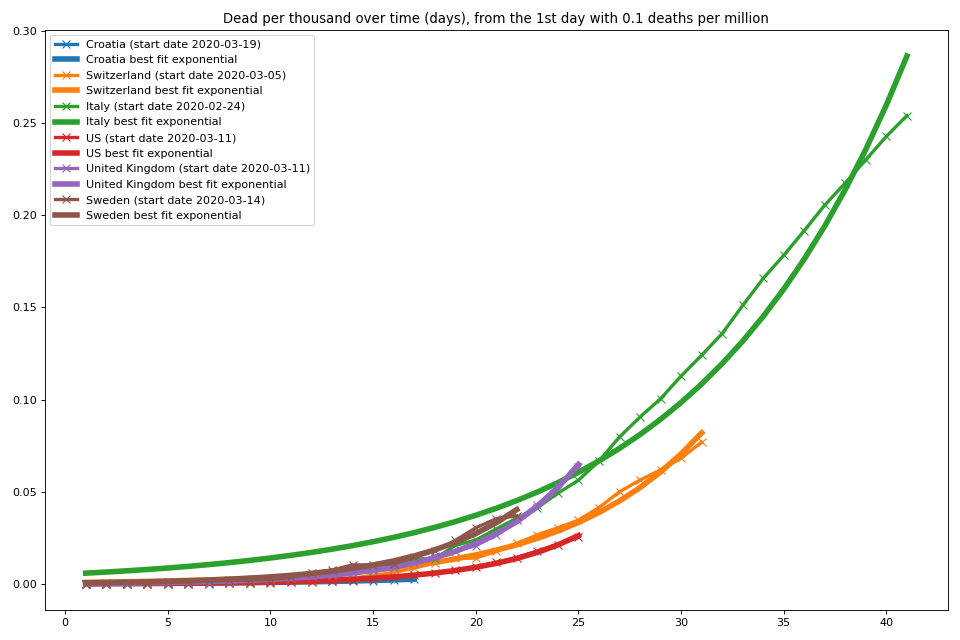

<IPython.core.display.Javascript object>


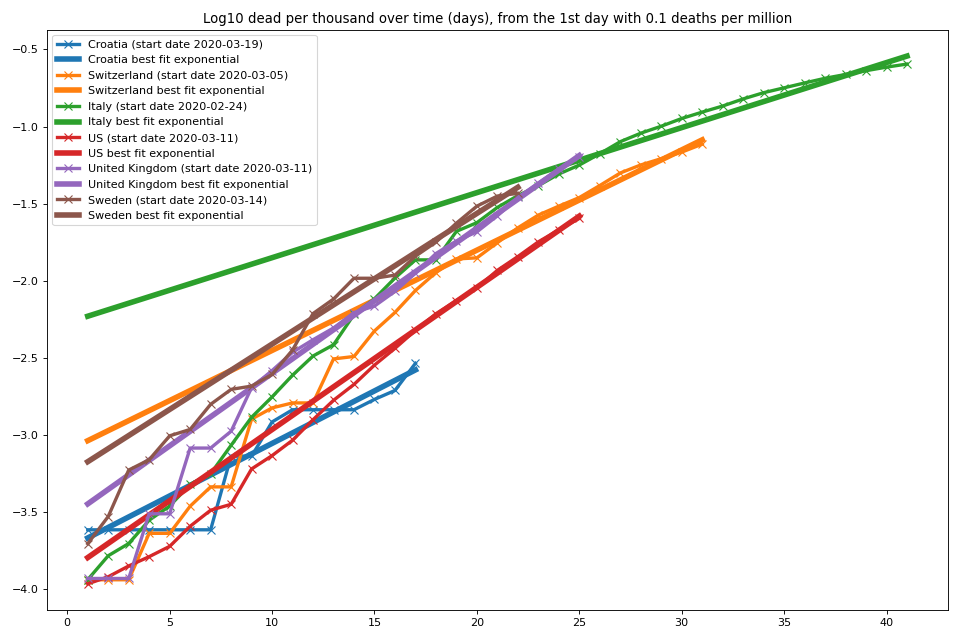

In [7]:
compare_countries_relative_dates('dead', start_info=(0.0001, '0.1 deaths per million'))